In [1]:
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scvi
import scanpy as sc

%load_ext nb_black
use_cuda = True


In [2]:
import sys
data_path = "../../../TabulaSapiensData/"
ts_path = "../"
sys.path.append(ts_path)


In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
adata = read_h5ad(data_path + "decontX/Pilot1_Pilot2.decontX.h5ad")

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.
  warnings.warn(problem)
/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


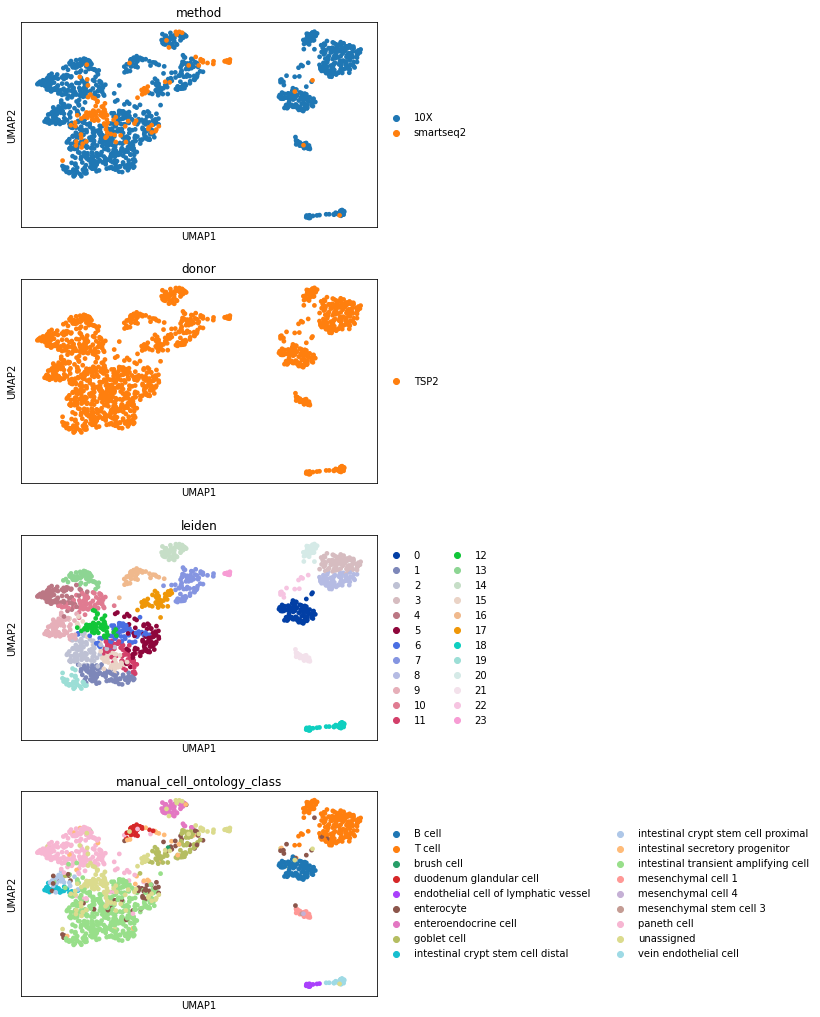

In [5]:
organ = "Small_Intestine"
organ_adata = adata[adata.obs["tissue"] == organ]
sc.pp.neighbors(organ_adata, use_rep="X_scvi_decontX")
sc.tl.umap(organ_adata)
organ_adata.obsm["X_umap_decontX"] = organ_adata.obsm["X_umap"].copy()
sc.tl.leiden(organ_adata, resolution=2)
sc.pl.umap(
    organ_adata,
    color=["method", "donor", "leiden", "manual_cell_ontology_class"],
    ncols=1,
)
organ_adata.X = np.log1p(organ_adata.X)

# cluster to celltype correspondance
count is a matrix of cluster-cell type correspondance, where each row is a celltype, and each colum is a cluster. The entries to the matrix is the number of cells that is annotated as celltype *X* and cluster *Y*

In [6]:
count = {}
for c in np.unique(organ_adata.obs["leiden"]):
    count[c] = {}
    for t in np.unique(organ_adata.obs["manual_cell_ontology_class"]):
        count[c][t] = np.sum(
            (organ_adata.obs["leiden"].astype(str) == c)
            & (organ_adata.obs["manual_cell_ontology_class"] == t)
        )

count = pd.DataFrame.from_dict(count)

We can visualize the cluster assignment of each cell type through this heatmap. The color is normalized for each celltype 

<AxesSubplot:>

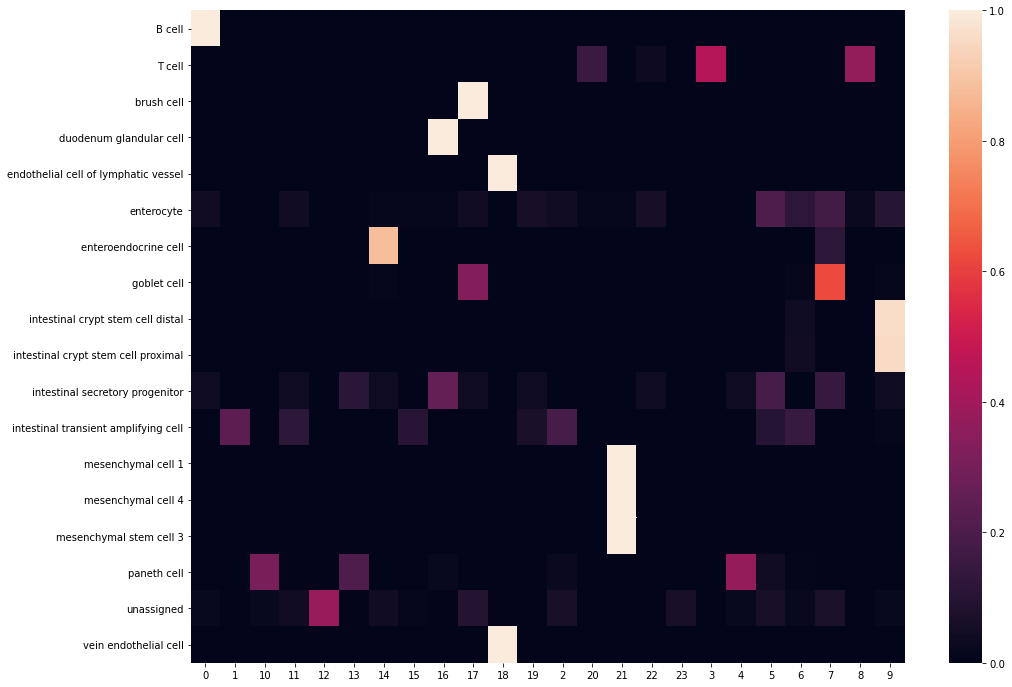

In [7]:
import seaborn

plt.figure(figsize=(16, 12))
seaborn.heatmap((count.T / count.sum(axis=1)).T)

# dictionary of cell type composition of each cluster 
What are clusters previously annotated as 

In [8]:
cluster_composition = {}
for x in count.columns.values:
    t = count.index[count[x] > 0].values
    freq = np.asarray([count.loc[y, x] for y in t]) / count[x].sum()
    res = [a + ": %.2f" % b for a, b in zip(t, freq)]
    cluster_composition[x] = res

In [9]:
cluster_composition["0"]

['B cell: 0.93',
 'enterocyte: 0.03',
 'intestinal secretory progenitor: 0.01',
 'unassigned: 0.03']

# Reassign pure clusters
If a cluster is very pure (>95% of annotated cells come from the same celltype, we reassign the clusters to all have the same labels) 

In [10]:
def Purity(x):
    names = x.index
    x = np.asarray(x).ravel()
    x = x[names != "unassigned"]
    return (np.max(x) / np.sum(x), names[np.argmax(x)])

In [11]:
cluster_purity = count.apply(Purity, axis=0).T
confident_clusters = cluster_purity[cluster_purity[0] > 0.95].index

<ipython-input-1-963029a66ab7>:5: RuntimeWarning: invalid value encountered in long_scalars
  return (np.max(x) / np.sum(x), names[np.argmax(x)])


In [12]:
for i in confident_clusters:
    organ_adata.obs.loc[
        organ_adata.obs["leiden"] == i, "new_manual_cell_ontology_class"
    ] = cluster_purity.loc[i, 1]

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'new_manual_cell_ontology_class' as categorical


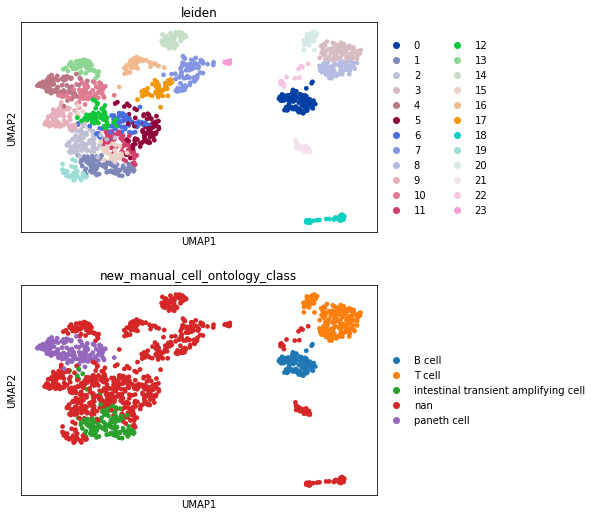

In [13]:
sc.pl.umap(
    organ_adata,
    color=["leiden", "new_manual_cell_ontology_class"],
    ncols=1,
)

In [14]:
organ_adata.obs.groupby(["leiden"]).agg(
    {"new_manual_cell_ontology_class": set, "Propagated.Annotation": set}
)

new_manual_cell_ontology_class  \
leiden                                           
0                                     {B cell}   
1       {intestinal transient amplifying cell}   
2                                        {nan}   
3                                     {T cell}   
4                                {paneth cell}   
5                                        {nan}   
6                                        {nan}   
7                                        {nan}   
8                                     {T cell}   
9                                        {nan}   
10                               {paneth cell}   
11                                       {nan}   
12                                       {nan}   
13                                       {nan}   
14                                       {nan}   
15      {intestinal transient amplifying cell}   
16                                       {nan}   
17                                       {nan}   
18                                       {nan}   
19                                       {nan}   
20                                    {T cell}   
21                                       {nan}   
22                                       {nan}   
23                                       {nan}   

                                    Propagated.Annotation  
leiden                                                     
0                                                {B cell}  
1                  {intestinal transient amplifying cell}  
2       {intestinal crypt stem cell proximal, paneth c...  
3                                                {T cell}  
4       {paneth cell, intestinal secretory progenitor,...  
5       {goblet cell, paneth cell, intestinal secretor...  
6       {intestinal crypt stem cell distal, goblet cel...  
7       {intestinal crypt stem cell distal, duodenum g...  
8                                                {T cell}  
9       {intestinal crypt stem cell distal, paneth cel...  
10                                          {paneth cell}  
11      {paneth cell, intestinal secretory progenitor,...  
12      {intestinal crypt stem cell distal, B cell, pa...  
13         {paneth cell, intestinal secretory progenitor}  
14            {B cell, goblet cell, enteroendocrine cell}  
15      {intestinal crypt stem cell proximal, paneth c...  
16      {duodenum glandular cell, paneth cell, goblet ...  
17      {brush cell, goblet cell, intestinal transient...  
18      {endothelial cell of lymphatic vessel, vein en...  
19                 {intestinal transient amplifying cell}  
20                                               {T cell}  
21                           {mesenchymal cell 1, T cell}  
22                                       {B cell, T cell}  
23               {fibroblast, B cell, classical monocyte}

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


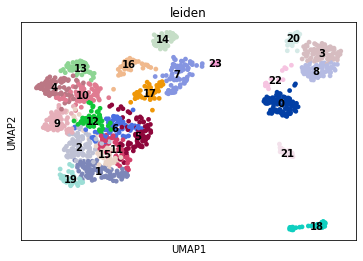

In [15]:
sc.pl.umap(organ_adata, color="leiden", legend_loc="on data")

# Sankey Diagram between cluster and compartment

In [16]:
from utils.colorDict import (
    donor_colors,
    method_colors,
    compartment_colors,
    tissue_colors,
)

In [17]:
from utils.plotting_utils import *
from utils.colorDict import compartment_colors

import plotly
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import plotly.io as pio

pio.renderers.default = "notebook"

init_notebook_mode(connected=True)

In [18]:
df = pd.DataFrame(columns=["celltype", "compartment", "count"])
for t in np.unique(organ_adata.obs["manual_cell_ontology_class"]):
    for c in np.unique(organ_adata.obs["compartment_pred_svm"]):
        x = np.sum(
            (organ_adata.obs["compartment_pred_svm"].astype(str) == c)
            & (organ_adata.obs["manual_cell_ontology_class"] == t)
        )
        df = df.append(
            pd.DataFrame([t, c, x], index=["celltype", "compartment", "count"]).T,
            ignore_index=True,
        )


fig = genSankey(
    df,
    cat_cols_color=[compartment_colors(), "#00A1E0"],
    cat_cols=["compartment", "celltype"],
    value_cols="count",
    title="celltype-compartment",
)
iplot(fig, validate=False)
plotly.offline.plot(
    fig, validate=False, filename="figures/celltype_sankey_%s" % organ + ".html"
)  # , output_type='div')

'figures/celltype_sankey_Small_Intestine.html'

# visualize compartment markers

In [19]:
compartment_markers = {
    "Epithelial": ["CDH1", "CLDN4", "EPCAM"],
    "Endothelial": ["CA4", "CDH5", "CLDN5", "PECAM1", "VWF"],
    "Stromal": ["BGN", "DCN", "COL1A2"],
    "Immune": ["LCP1", "PTPRC", "RAC2"],
}

In [20]:
for x in compartment_markers.keys():
    sc.tl.score_genes(organ_adata, compartment_markers[x], score_name="%s_score" % x)

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



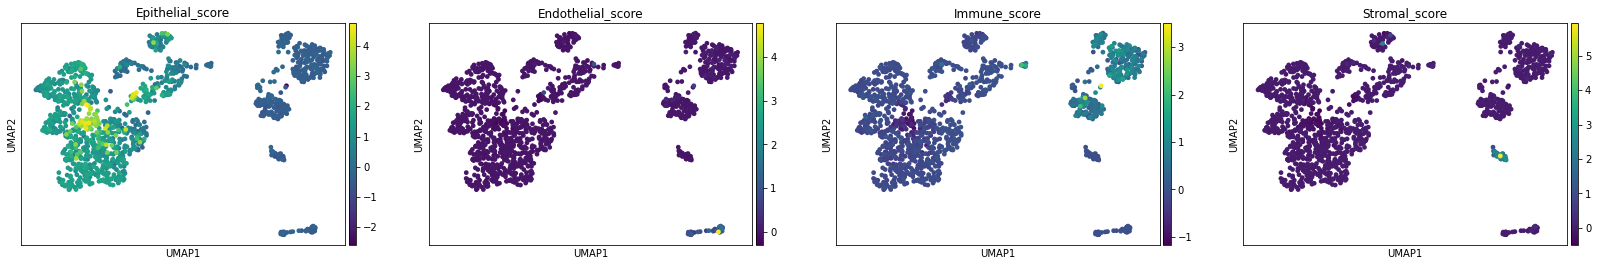

In [21]:
sc.pl.umap(
    organ_adata,
    color=["Epithelial_score", "Endothelial_score", "Immune_score", "Stromal_score"],
)

# Find markers for each cluster

In [22]:
sc.tl.rank_genes_groups(organ_adata, groupby="leiden", method="wilcoxon")

In [23]:
def FormatDE(res):
    groups = res['scores'].dtype.names
    df_res = {}
    for group in groups:
        df = pd.DataFrame([res['scores'][group],
                           res['logfoldchanges'][group],res['pvals_adj'][group]], 
                           columns=res['names'][group],
                           index=['wilcoxon_score','log fold change','adjusted pvalue'])
        df_res[group] = df
    return df_res


In [24]:
DE = FormatDE(organ_adata.uns["rank_genes_groups"])

### top positive marker genes

In [25]:
organ_cluster_genes = pd.DataFrame(organ_adata.uns['rank_genes_groups']['names'])
organ_cluster_genes.iloc[:20]


0        1        2        3           4       5       6  \
0      LAPTM5    FABP1    OLFM4     CCL5  AC020656.1    RBP2   STMN1   
1       CXCR4   SLC51B    DMBT1     CD69         LYZ    MT1H  TUBA1B   
2    HLA-DPA1   UGT2A3    REG1A     IL7R       FOXQ1   GSTA1   H2AFZ   
3      GPR183     GBA3     CHP2     CD3E       GDF15    MT1G   PCLAF   
4        CD37     RBP2     CPS1    CXCR4       GOLM1   REG1A     TK1   
5       CD79A   CYBRD1  SLC12A2     CD3D        MUC1   FABP1    TUBB   
6        CD83      KHK     MAOA     SRGN       VSIG2   PTGR1    SMC2   
7       MS4A1     VNN1   CLDN15     CD48      GPRC5A    MT2A  MAD2L1   
8       SMAP2    HEBP1   CLINT1    CYTIP        CTSE    MT1X   HMGB1   
9   TNFRSF13C     MALL     PIGR      CD2        MLPH   FABP2   HMGB2   
10   HLA-DPB1    ANPEP    PCSK5     CCL4        LIPH    MT1E   CENPW   
11    HLA-DRA    AADAC     MLEC    PTPRC        LMO4   CCL25   NUDT1   
12       CD53     PCK2  HNRNPAB  ARHGDIB      SQSTM1   OLFM4   HMGN2   
13       CD52   SLC5A1   MGAT4B     CD8A        KLF4  AKR1C3   ZWINT   
14      BANK1    PTGR1    HSPD1     HCST      ANXA10   GSTA2  ALYREF   
15   HLA-DQA1      MME     TFRC    ANXA1       FXYD3    MT1M   DTYMK   
16    TSC22D3  HSD17B2    UQCRH     TRAC         GP2   ALDOB   HMGB3   
17       SRGN    ALDOB      MME     RGS1        RHOB   ADH1C   PTTG1   
18       KLF2  SLC13A2    CCND2     CD3G     TACSTD2   PHGR1    RPA3   
19      IGHA1    DGAT1      VDR    DUSP2       EFNB2    CBR1    LSM3   

           7          8         9  ...        14       15          16  \
0      FCGBP       SRGN       CEL  ...      SCGN    HEBP1        MUC6   
1      CLCA1  LINC-PINT      RGMB  ...    PCSK1N      SFN     C6orf58   
2       TFF3      PTPRC   SLC12A2  ...      CHGB      ADA        TFF2   
3       MUC2       CCL5      CDK6  ...   NEUROD1   MGAT4B         PGC   
4      ITLN1    TNFAIP3     OLFM4  ...      CHGA    NAPRT         LYZ   
5   HEPACAM2       IL7R     ASCL2  ...    KCTD12    FABP1  AC020656.1   
6      BCAS1      CXCR4     CDCA7  ...   CACNA1A     CPS1  AC139749.1   
7       ANO7    ARHGDIB     EPHB2  ...      SCG5    GSTA2        AQP5   
8      RAB26      SYTL3    MT-ND3  ...      SCG3    KRT19        FMOD   
9       DLL1       CD69      SOX4  ...    NKX2-2    ANPEP       NUCB2   
10     REP15       CCL4   MT-RNR1  ...     PCSK1   METRNL        SOD3   
11    SCNN1A       CD8A     CCND2  ...       SCT    HBEGF         GP2   
12     SYTL2        VIM      GAS5  ...     MS4A8    ITPKC    C16orf89   
13     PRSS2       CD53  MARCKSL1  ...       CPE     RBP2   LINC00632   
14      HES6    TSC22D3     CCL25  ...       TTR     FIS1        CD24   
15    GALNT5       CD3D     REG1A  ...       F10     PCK2       KCNE2   
16    NEURL1   LEPROTL1  KIAA1324  ...  C12orf75   HSPA1B        IFI6   
17      ZG16       RGCC   MT-RNR2  ...    SNAP25     MAOA       ZG16B   
18      REG4       CD3E      QPRT  ...  C15orf48  CHCHD10       PDIA2   
19    RASSF6       CCNH   MT-ATP6  ...     MAP1B    PSME2        TESC   

           17      18        19      20       21          22       23  
0        HES6     VIM    SLC5A1    CD3G   IGFBP6        MZB1    CSF3R  
1        TFF3   CLDN5  TMPRSS15   IKZF1   IGFBP5      JCHAIN   S100A9  
2         MDK  PECAM1      VNN1    CD3E      DCN        IGKC   IFITM2  
3    MARCKSL1  IGFBP7       MME    CD3D    FBLN1       IGLC2     LCP1  
4       STMN1    CAV1    UGT2A3    CCL5    SFRP1       IGHA2     FPR1  
5    HEPACAM2  CAVIN2    SLC2A2    IL7R    FSTL1       IGHA1     SAT1  
6      TMSB10   TIMP3      MTTP    CD8A    ADH1B      CORO1A      SLA  
7         TOX   GNG11   SLC13A2     CD2      MGP       CD79A   SAMSN1  
8       H3F3A     VWF      SGK1    HCST      CFD       CXCR4     G0S2  
9        CD24  TGFBR2    CYBRD1   PTPRC      C1R  AC055748.1   S100A8  
10       SOX4   CRIP2        SI   ACAP1    TIMP3    TNFRSF17    IL1R2  
11   SH3BGRL3   EGFL7      APOB     CD7     GPX3        IGHM    NLRP3  
12   KIAA1324  CAVIN1     ANP

In [26]:
for x in DE.keys():
    print(x)
    display(DE[x].T[:20])

0


wilcoxon_score  log fold change  adjusted pvalue
LAPTM5          14.674339         5.268868     5.541279e-44
CXCR4           14.089197         5.046943     8.580366e-41
HLA-DPA1        14.081161         6.548367     8.580366e-41
GPR183          14.069719         6.054896     8.580366e-41
CD37            13.961026         5.050691     3.173375e-40
CD79A           13.776058         9.398323     3.484530e-39
CD83            13.421104         5.998626     2.975458e-37
MS4A1           12.738301         8.556555     1.332657e-33
SMAP2           12.677825         3.155227     2.566703e-33
TNFRSF13C       12.419987         8.864531     4.132996e-32
HLA-DPB1        12.060674         5.222216     2.639593e-30
HLA-DRA         12.020084         2.921499     4.101575e-30
CD53            11.945851         3.820148     9.799348e-30
CD52            11.662270         3.726983     2.165916e-28
BANK1           11.635437         4.452094     2.913441e-28
HLA-DQA1        11.598798        10.109681     4.100373e-28
TSC22D3         11.509310         2.365586     9.959289e-28
SRGN            11.413693         3.521930     2.662064e-27
KLF2            11.286613         3.173346     1.066596e-26
IGHA1           11.192903         6.661468     2.921889e-26

1


wilcoxon_score  log fold change  adjusted pvalue
FABP1         12.641808         4.532503     7.309662e-32
SLC51B        12.406204         3.293675     5.673640e-31
UGT2A3        12.391895         3.076315     5.673640e-31
GBA3          12.197519         2.916578     4.716030e-30
RBP2          12.170460         4.716391     5.257786e-30
CYBRD1        12.150484         2.591964     5.595299e-30
KHK           12.105857         2.623564     8.270152e-30
VNN1          11.847019         3.111763     1.640865e-28
HEBP1         11.812168         2.742483     2.209193e-28
MALL          11.789500         2.815547     2.602986e-28
ANPEP         11.753940         3.400264     3.607196e-28
AADAC         11.719938         2.798811     4.942399e-28
PCK2          11.556730         2.753678     3.091060e-27
SLC5A1        11.548656         2.779564     3.153105e-27
PTGR1         11.453592         3.262806     8.854005e-27
MME           11.418882         2.789248     1.238237e-26
HSD17B2       11.410807         2.362430     1.278823e-26
ALDOB         11.286417         3.326406     5.008942e-26
SLC13A2       11.259357         2.442253     6.453107e-26
DGAT1         11.160045         2.229054     1.818894e-25

2


wilcoxon_score  log fold change  adjusted pvalue
OLFM4         11.148571         4.871006     4.283701e-24
DMBT1         11.018922         3.603830     9.117437e-24
REG1A         10.758175         5.049942     1.064242e-22
CHP2          10.368358         2.522603     5.083563e-21
CPS1          10.344482         2.951570     5.219466e-21
SLC12A2       10.251586         2.630420     1.142246e-20
MAOA           9.898522         2.477733     3.552978e-19
CLDN15         9.785224         2.561499     9.588962e-19
CLINT1         9.741380         2.152861     1.313511e-18
PIGR           9.709112         3.700686     1.623210e-18
PCSK5          9.685961         2.425807     1.851414e-18
MLEC           9.663677         2.171752     2.110203e-18
HNRNPAB        9.555588         2.027540     5.564793e-18
MGAT4B         9.529542         2.195110     6.278414e-18
HSPD1          9.528239         2.354039     6.278414e-18
TFRC           9.483962         2.322133     9.007404e-18
UQCRH          9.468479         2.132841     9.832953e-18
MME            9.460666         2.554204     9.937508e-18
CCND2          9.455746         2.229617     9.937508e-18
VDR            9.443157         2.250941     1.000536e-17

3


wilcoxon_score  log fold change  adjusted pvalue
CCL5          14.026005         5.743324     6.362088e-40
CD69          13.470834         5.064438     6.835672e-37
IL7R          13.286470         5.524129     5.442622e-36
CD3E          12.988276         4.600548     2.098756e-34
CXCR4         12.560924         4.333068     4.076947e-32
CD3D          11.833591         4.553497     2.200912e-28
SRGN          11.620064         3.509365     2.398177e-27
CD48          11.142714         3.952229     1.759632e-25
CYTIP         10.666258         2.681459     1.596086e-23
CD2           10.634117         4.279549     2.028843e-23
CCL4          10.434576         4.601284     1.254811e-22
PTPRC         10.427434         3.210926     1.331282e-22
ARHGDIB       10.102158         3.178230     2.428488e-21
CD8A          10.092040         4.152530     2.655898e-21
HCST           9.852919         3.909641     2.165568e-20
ANXA1          9.848157         3.611821     2.239231e-20
TRAC           9.744593         3.998056     5.560017e-20
RGS1           9.458450         4.235281     6.789378e-19
CD3G           9.405180         4.106665     1.058052e-18
DUSP2          9.383902         3.188504     1.273021e-18

4


wilcoxon_score  log fold change  adjusted pvalue
AC020656.1       12.556767         4.910474     1.174026e-31
LYZ              12.549733         6.149055     1.174026e-31
FOXQ1            11.948669         3.675478     1.294603e-28
GDF15            11.317524         3.985846     1.581609e-25
GOLM1            11.220241         3.101311     3.819342e-25
MUC1             11.105146         3.292172     1.161929e-24
VSIG2            11.027918         3.494594     2.357139e-24
GPRC5A           10.930036         3.220957     6.094200e-24
CTSE             10.749687         3.539860     3.889543e-23
MLPH             10.582958         3.210789     2.104548e-22
LIPH             10.484178         2.378149     5.465824e-22
LMO4             10.464571         2.851235     6.163885e-22
SQSTM1           10.449306         2.221536     6.684122e-22
KLF4             10.425658         2.491786     7.961935e-22
ANXA10           10.390186         3.454864     1.078555e-21
FXYD3            10.171823         2.621464     9.258479e-21
GP2              10.170924         2.949651     9.258479e-21
RHOB             10.087111         2.528965     2.060329e-20
TACSTD2          10.042510         3.436519     3.071128e-20
EFNB2            10.035176         2.333489     3.142725e-20

5


wilcoxon_score  log fold change  adjusted pvalue
RBP2          5.460787         2.046925         0.000016
MT1H          5.161507         1.472684         0.000057
GSTA1         5.041794         1.731872         0.000098
MT1G          4.777379         1.966106         0.000285
REG1A         4.299456         2.312857         0.001626
FABP1         4.146730         1.109406         0.002777
PTGR1         3.998941         0.981356         0.004596
MT2A          3.964539         1.233045         0.005105
MT1X          3.853929         1.080492         0.007334
FABP2         3.778492         1.042723         0.009289
MT1E          3.715859         1.318930         0.011111
CCL25         3.713545         1.309332         0.011182
OLFM4         3.596301         0.822813         0.015626
AKR1C3        3.438330         1.133236         0.024232
GSTA2         3.189033         0.867170         0.048103
MT1M          3.150157         0.866140         0.053518
ALDOB         3.141364         0.583419         0.054786
ADH1C         2.955625         0.992219         0.088528
PHGR1         2.903328         1.313857         0.100723
CBR1          2.893764         0.592753         0.103224

6


wilcoxon_score  log fold change  adjusted pvalue
STMN1        12.346178         4.336454     3.007124e-30
TUBA1B       11.836357         3.792553     7.453372e-28
H2AFZ        11.402626         3.091293     7.961071e-26
PCLAF        11.215446         5.498330     5.040052e-25
TK1          11.138419         4.976029     9.602215e-25
TUBB         10.861712         3.383595     1.721248e-23
SMC2         10.696563         3.771108     8.882931e-23
MAD2L1       10.610317         4.630913     1.963626e-22
HMGB1        10.518759         2.339871     4.631130e-22
HMGB2        10.466573         3.118130     7.241943e-22
CENPW        10.315173         5.765536     3.220321e-21
NUDT1        10.285487         3.421102     4.019178e-21
HMGN2        10.242520         2.558691     5.790144e-21
ZWINT        10.145181         4.152571     1.463897e-20
ALYREF       10.119245         2.612169     1.781425e-20
DTYMK        10.079247         3.387098     2.511082e-20
HMGB3        10.013624         2.948558     4.598665e-20
PTTG1        10.001437         5.369519     4.912406e-20
RPA3          9.933784         2.631789     9.195326e-20
LSM3          9.927534         2.294416     9.300639e-20

7


wilcoxon_score  log fold change  adjusted pvalue
FCGBP           8.614975         5.506208     1.855116e-15
CLCA1           8.111107         7.064402     9.556475e-14
TFF3            8.029174         3.773496     1.750603e-13
MUC2            6.691188         8.082733     1.896199e-09
ITLN1           6.571354         4.886271     4.065433e-09
HEPACAM2        6.419281         2.747544     1.052274e-08
BCAS1           6.416294         2.530528     1.070330e-08
ANO7            6.081482         4.678984     7.652860e-08
RAB26           5.981779         2.886473     1.356310e-07
DLL1            5.528863         3.544320     1.610738e-06
REP15           5.135866         4.079601     1.186901e-05
SCNN1A          4.830306         1.335579     5.079356e-05
SYTL2           4.761267         1.880538     7.008336e-05
PRSS2           4.495966         4.321691     2.267535e-04
HES6            4.474736         1.201184     2.480121e-04
GALNT5          4.456651         2.903479     2.679570e-04
NEURL1          4.325651         2.484041     4.682562e-04
ZG16            4.180184         3.373596     8.463608e-04
REG4            4.112404         1.987455     1.108762e-03
RASSF6          4.099351         1.033774     1.167006e-03

8


wilcoxon_score  log fold change  adjusted pvalue
SRGN            12.749664         4.557685     1.843166e-32
LINC-PINT       12.057787         3.599301     5.194115e-29
PTPRC           11.809886         4.079853     6.809921e-28
CCL5            11.750678         5.046867     1.031022e-27
TNFAIP3         11.653765         3.861470     2.584888e-27
IL7R            11.633226         5.639501     2.740758e-27
CXCR4           11.482239         4.264320     1.362665e-26
ARHGDIB         10.962850         3.517064     3.771252e-24
SYTL3           10.847484         4.449550     1.206784e-23
CD69            10.673712         3.787811     7.231279e-23
CCL4            10.413135         5.134352     7.479584e-22
CD8A            10.252681         4.218815     3.226792e-21
VIM              9.794104         2.920841     2.007481e-19
CD53             9.680823         3.140985     4.655512e-19
TSC22D3          9.625467         2.180695     6.805234e-19
CD3D             9.597227         3.844826     8.481827e-19
LEPROTL1         9.515395         2.419726     1.522401e-18
RGCC             9.412705         5.072753     3.558169e-18
CD3E             9.394734         3.802383     4.068584e-18
CCNH             9.189033         1.943144     2.102298e-17

9


wilcoxon_score  log fold change  adjusted pvalue
CEL            10.994905         4.963315     2.380330e-23
RGMB           10.155257         3.508324     9.242052e-20
SLC12A2         9.463088         3.008866     5.237474e-17
CDK6            9.423104         3.126188     5.237474e-17
OLFM4           9.421466         4.760952     5.237474e-17
ASCL2           9.391315         4.183753     5.814004e-17
CDCA7           9.163541         3.143912     4.223645e-16
EPHB2           8.939209         2.865067     2.884387e-15
MT-ND3          8.891851         1.774553     3.931141e-15
SOX4            8.816146         2.618339     6.974184e-15
MT-RNR1         8.695540         1.441775     1.847359e-14
CCND2           8.377149         2.145388     2.660199e-13
GAS5            8.324057         1.750671     3.849334e-13
MARCKSL1        8.170186         2.027658     1.294776e-12
CCL25           8.161665         2.854172     1.296854e-12
REG1A           8.133972         4.199765     1.528591e-12
KIAA1324        8.034178         2.007359     3.262386e-12
MT-RNR2         7.976825         1.210022     4.802668e-12
QPRT            7.972892         2.157761     4.802668e-12
MT-ATP6         7.952409         1.522778     5.384240e-12

10


wilcoxon_score  log fold change  adjusted pvalue
LMO4             10.710107         3.059996     5.372273e-22
LYZ              10.496426         5.320426     2.640703e-21
GP2              10.448249         3.525903     2.928884e-21
ANXA10           10.199992         3.672937     2.918304e-20
FXYD3             9.825232         2.715958     9.270117e-19
AC020656.1        9.817694         3.408557     9.270117e-19
VSIG2             9.698071         3.320020     2.583984e-18
SLC4A4            9.645798         2.739615     3.768506e-18
AKR1C1            9.569928         2.780499     6.480137e-18
MUC1              9.566978         3.099886     6.480137e-18
CTSE              9.411798         3.166890     2.610202e-17
FOXQ1             9.350512         3.013577     4.279089e-17
CA2               9.306268         2.774639     5.995806e-17
HPGD              9.288406         2.900286     6.585660e-17
C19orf33          9.192873         2.433785     1.501132e-16
MLPH              9.177306         3.128269     1.626327e-16
GOLM1             9.060634         2.695449     4.491273e-16
AK4               8.937243         2.796075     1.304961e-15
MSMB              8.897915         3.457138     1.763182e-15
ADH1C             8.874973         2.810778     2.058984e-15

11


wilcoxon_score  log fold change  adjusted pvalue
FABP1          9.303739         4.430667     5.238838e-16
RBP2           9.274784         4.944378     5.238838e-16
GSTA1          9.008115         4.304514     3.543118e-15
AADAC          8.992923         3.326300     3.543118e-15
MT1H           8.741982         3.509769     2.696900e-14
HSD17B2        8.716066         2.853428     2.826107e-14
SLC51B         8.665306         3.349347     3.787038e-14
PTGR1          8.626879         3.417787     4.288310e-14
PRSS3          8.622410         2.673474     4.288310e-14
VNN1           8.570757         3.129550     5.505345e-14
KHK            8.563607         2.798372     5.505345e-14
AKR1C3         8.557530         3.340047     5.505345e-14
GSTA2          8.546985         3.426723     5.505345e-14
HEBP1          8.542874         2.835448     5.505345e-14
UGT2A3         8.533223         2.827710     5.585832e-14
GBA3           8.476207         2.855437     8.560229e-14
CISD3          8.440104         2.251415     1.097952e-13
CBR1           8.408467         3.148712     1.358597e-13
MGST3          8.383624         2.595357     1.590193e-13
SLC5A1         8.363427         2.736589     1.793247e-13

12


wilcoxon_score  log fold change  adjusted pvalue
EEF1A1P6         12.156201         8.565222     2.320074e-30
EEF1A1           12.148858         6.632874     2.320074e-30
EEF1A1P5         12.142798         9.737129     2.320074e-30
DNAJB1           12.127927         9.217735     2.320074e-30
ELF3             12.110485         8.049288     2.320074e-30
TOB1             12.108832         9.374934     2.320074e-30
MT-CO1           12.105895         7.883986     2.320074e-30
TSPYL1           12.104609         7.672894     2.320074e-30
KRT8P3           12.103141         9.217093     2.320074e-30
EPCAM            12.101489         9.157906     2.320074e-30
KRT8             12.101122         9.157351     2.320074e-30
AC008038.1       12.100204         6.203902     2.320074e-30
UBC              12.095981         7.883376     2.320074e-30
MT-CYB           12.087902         7.890726     2.320074e-30
PIGR             12.083129         8.943265     2.320074e-30
CLDN4            12.079273         8.368766     2.320074e-30
TSPAN3           12.077621         7.653646     2.320074e-30
RPL7P9           12.070460         8.216800     2.320074e-30
RPL13AP5         12.068808         9.292752     2.320074e-30
RPS2P5           12.063850         9.989958     2.320074e-30

13


wilcoxon_score  log fold change  adjusted pvalue
CTSE           10.879851         5.335382     8.465372e-23
MSMB           10.289751         5.067938     2.307084e-20
TSPAN1          9.999374         3.629932     3.009478e-19
HPGD            9.850389         3.884015     1.004898e-18
VSIG2           9.819229         3.884099     1.095603e-18
FXYD3           9.785731         3.492088     1.272128e-18
ANXA10          9.753013         4.338385     1.506006e-18
LMO4            9.642588         3.405007     3.888265e-18
CA2             9.114614         3.332304     5.164275e-16
SLC26A3         9.064563         4.124248     7.364944e-16
RAB27B          8.835144         3.391511     5.350177e-15
NQO1            8.767565         2.950599     8.956665e-15
CAPN8           8.606115         3.727070     3.422539e-14
TMEM54          8.438823         2.314830     1.347913e-13
RNASE1          8.383708         2.704606     2.012807e-13
GALNT6          8.320803         2.807694     3.214657e-13
GCNT3           8.304638         2.453487     3.339696e-13
C12orf75        8.302301         2.548494     3.339696e-13
PLA2G10         8.291201         3.165619     3.473683e-13
REG4            8.228490         5.170402     5.580532e-13

14


wilcoxon_score  log fold change  adjusted pvalue
SCGN           11.468004         9.923041     1.124505e-25
PCSK1N         11.282989        12.813622     4.687289e-25
CHGB           11.010530        11.996173     6.671886e-24
NEUROD1        10.950157         9.061775     9.762521e-24
CHGA           10.704768        10.545035     1.138216e-22
KCTD12         10.443216         6.524183     1.544228e-21
CACNA1A        10.391217         7.812404     2.179653e-21
SCG5           10.383038         8.764803     2.179653e-21
SCG3           10.213798         8.434136     1.125063e-20
NKX2-2         10.138039         7.174194     2.204941e-20
PCSK1           9.705298         8.610486     1.531890e-18
SCT             9.683681         8.037680     1.735415e-18
MS4A8           9.606559         4.183425     3.396983e-18
CPE             9.491655         6.926179     9.561963e-18
TTR             9.390773         8.496688     2.337589e-17
F10             9.316572         6.200521     4.421114e-17
C12orf75        9.300408         3.820656     4.844928e-17
SNAP25          9.254057         9.769727     7.068656e-17
C15orf48        9.235166         4.000045     7.990404e-17
MAP1B           9.140905         7.502647     1.822955e-16

15


wilcoxon_score  log fold change  adjusted pvalue
HEBP1          7.366491         2.247251     8.204322e-09
SFN            7.304294         2.721698     8.204322e-09
ADA            6.973229         2.221724     6.078293e-08
MGAT4B         6.829151         1.895224     8.164236e-08
NAPRT          6.807696         1.749286     8.164236e-08
FABP1          6.801595         3.092063     8.164236e-08
CPS1           6.774236         2.217015     8.164236e-08
GSTA2          6.769905         2.512734     8.164236e-08
KRT19          6.769315         2.719310     8.164236e-08
ANPEP          6.759276         2.601902     8.164236e-08
METRNL         6.737429         1.860949     8.627884e-08
HBEGF          6.703180         2.143684     1.000453e-07
ITPKC          6.654564         2.008115     1.159268e-07
RBP2           6.649250         3.493619     1.159268e-07
FIS1           6.648856         1.501336     1.159268e-07
PCK2           6.586658         2.024145     1.614560e-07
HSPA1B         6.575636         2.202540     1.614560e-07
MAOA           6.565401         2.051093     1.614560e-07
CHCHD10        6.563236         1.982645     1.614560e-07
PSME2          6.557134         1.765326     1.614560e-07

16


wilcoxon_score  log fold change  adjusted pvalue
MUC6             10.715692        10.688540     5.057683e-22
C6orf58          10.639583        10.340495     5.739850e-22
TFF2             10.584027        10.156043     6.935532e-22
PGC              10.486550        10.291043     1.465836e-21
LYZ              10.297092         8.241723     8.550661e-21
AC020656.1       10.167463         6.530881     2.718129e-20
AC139749.1        9.945445         8.515830     2.220176e-19
AQP5              9.894773         7.809884     3.227574e-19
FMOD              9.817850         6.822162     6.170474e-19
NUCB2             9.376459         4.510583     4.016436e-17
SOD3              9.104177         6.076423     4.651989e-16
GP2               8.993472         4.422820     1.175144e-15
C16orf89          8.722410         6.039213     1.233285e-14
LINC00632         8.552284         6.934849     5.074413e-14
CD24              8.487572         3.567765     8.281028e-14
KCNE2             8.412277         4.322229     1.479578e-13
IFI6              8.390706         4.345684     1.673405e-13
ZG16B             8.363234         5.091948     1.995770e-13
PDIA2             8.219563         4.968928     6.328433e-13
TESC              8.180898         4.736887     8.292946e-13

17


wilcoxon_score  log fold change  adjusted pvalue
HES6             9.678657         6.832527     2.187415e-17
TFF3             9.501408         7.318958     6.095144e-17
MDK              9.236451         5.636429     5.000187e-16
MARCKSL1         8.791600         3.730439     2.170011e-14
STMN1            8.380734         5.256851     6.192949e-13
HEPACAM2         8.245407         6.460956     1.614992e-12
TMSB10           8.125953         3.553545     3.732887e-12
TOX              8.081182         3.998197     4.720029e-12
H3F3A            7.747239         2.557003     5.894275e-11
CD24             7.739100         3.811607     5.894275e-11
SOX4             7.710813         3.994623     6.690786e-11
SH3BGRL3         7.538042         3.311913     2.340486e-10
KIAA1324         7.526442         3.411425     2.361215e-10
CBFA2T2          7.451554         4.171243     3.878992e-10
SINHCAF          7.438123         2.999281     4.008103e-10
HIST1H2AC        7.391725         3.965279     5.332739e-10
RASD1            7.359368         4.883943     6.398899e-10
PTMA             7.308086         2.853984     8.862327e-10
MT-RNR2          7.274306         2.290148     1.078891e-09
GSE1             7.185580         4.009887     1.969868e-09

18


wilcoxon_score  log fold change  adjusted pvalue
VIM          10.190368         5.686027     1.288871e-19
CLDN5        10.090173        10.341221     1.797366e-19
PECAM1       10.011493         7.226430     2.142551e-19
IGFBP7       10.004532         6.408228     2.142551e-19
CAV1          9.724830         7.737575     2.782209e-18
CAVIN2        9.550595        10.836390     1.265243e-17
TIMP3         9.506510         5.428941     1.658176e-17
GNG11         9.452931         7.462564     2.424496e-17
VWF           9.014394        31.351631     1.294896e-15
TGFBR2        8.967144         3.934229     1.791432e-15
CRIP2         8.946894         4.818107     1.956764e-15
EGFL7         8.603699         6.701903     3.786672e-14
CAVIN1        8.509410         6.053219     7.916662e-14
IFITM2        8.454356         3.513529     1.180059e-13
GIMAP7        8.413434         5.425247     1.562717e-13
NNMT          8.405629         5.614127     1.565844e-13
LMO2          8.397824         7.365789     1.575035e-13
STOM          8.301427         4.956119     3.364379e-13
GIMAP4        8.266411         6.162365     4.277437e-13
ECSCR         8.194903        30.677538     7.030615e-13

19


wilcoxon_score  log fold change  adjusted pvalue
SLC5A1          7.365766         2.959453     5.947950e-09
TMPRSS15        7.347419         3.268082     5.947950e-09
VNN1            6.911502         3.138921     7.798364e-08
MME             6.897336         2.720796     7.798364e-08
UGT2A3          6.760545         2.691160     1.618613e-07
SLC2A2          6.645121         2.834075     2.588445e-07
MTTP            6.642799         2.565691     2.588445e-07
SLC13A2         6.605640         2.270254     2.739226e-07
SGK1            6.597280         2.093847     2.739226e-07
CYBRD1          6.578468         2.272729     2.798210e-07
SI              6.480462         2.437423     4.893815e-07
APOB            6.417757         3.094321     6.784611e-07
ANPEP           6.381295         2.933347     7.762612e-07
MALL            6.373631         2.375121     7.762612e-07
PCSK5           6.318822         1.995054     1.034402e-06
PCK2            6.301868         2.139128     1.082025e-06
SLC35G1         6.243344         2.326996     1.451645e-06
EMP1            6.237770         1.985588     1.451645e-06
ALDOB           6.191090         2.881722     1.758735e-06
FABP1           6.118630         3.190866     2.645875e-06

20


wilcoxon_score  log fold change  adjusted pvalue
CD3G          7.607373         4.370491     1.454798e-10
IKZF1         7.544992         4.199110     1.901989e-10
CD3E          7.473594         4.083993     2.871145e-10
CD3D          7.418767         4.018939     3.887710e-10
CCL5          7.298390         4.258111     7.143665e-10
IL7R          7.253797         4.341524     8.520326e-10
CD8A          6.436502         3.610254     5.331362e-08
CD2           6.382893         4.190795     6.865797e-08
HCST          6.219141         3.616626     1.557040e-07
PTPRC         6.167482         2.969159     1.992564e-07
ACAP1         5.837055         3.384956     9.867051e-07
CD7           5.589966         3.420125     3.116601e-06
KLRD1         5.368219         3.725113     9.002343e-06
ARL4C         5.157438         3.002770     2.388688e-05
GIMAP7        5.039985         3.321743     3.972168e-05
CD96          4.939103         3.252135     6.235203e-05
CD53          4.816533         2.375278     1.061626e-04
SYTL3         4.816289         2.573818     1.061626e-04
VIM           4.808979         1.659073     1.090448e-04
CELF2         4.709558         2.065478     1.660763e-04

21


wilcoxon_score  log fold change  adjusted pvalue
IGFBP6         9.219544        13.676473     2.496348e-16
IGFBP5         9.215646        12.499625     2.496348e-16
DCN            9.214915        13.168453     2.496348e-16
FBLN1          9.211260        12.021053     2.496348e-16
SFRP1          9.205655        10.249941     2.496348e-16
FSTL1          9.203462        10.299699     2.496348e-16
ADH1B          9.191766        10.103099     2.496348e-16
MGP            9.190547        10.339610     2.496348e-16
CFD            9.188354        11.853549     2.496348e-16
C1R            9.181775         9.759603     2.496348e-16
TIMP3          9.155214         8.343783     2.903374e-16
GPX3           9.130603         8.288015     3.341813e-16
LGALS1         9.116225         7.508520     3.522524e-16
TIMP2          9.079674         6.552763     4.579276e-16
GSN            9.038249         7.417867     6.248147e-16
SPARCL1        8.934929         7.492448     1.499120e-15
C3             8.898377        11.613182     1.857462e-15
MFAP5          8.898134        12.757870     1.857462e-15
COL6A2         8.888631         9.639620     1.916891e-15
C1S            8.875959        10.195949     2.040823e-15

22


wilcoxon_score  log fold change  adjusted pvalue
MZB1              2.429837         5.614280         0.431264
JCHAIN            2.408008         7.192237         0.452085
IGKC              2.242029         5.730815         0.608937
IGLC2             1.853993         5.499734         1.000000
IGHA2             1.820120         5.202842         1.000000
IGHA1             1.779472         6.015950         1.000000
CORO1A            1.672207         1.382259         1.000000
CD79A             1.536714         1.856220         1.000000
CXCR4             1.465204         1.021554         1.000000
AC055748.1        1.450902         5.230911         1.000000
TNFRSF17          1.448644         5.100630         1.000000
IGHM              1.412889         5.718672         1.000000
ZNF66             1.345895         3.052156         1.000000
CD69              1.274761         0.990584         1.000000
EAF2              1.255566         1.146624         1.000000
DERL3             1.253308         2.936096         1.000000
AC016831.5        1.225080         1.472374         1.000000
PARP8             1.215295         0.945642         1.000000
TMEM154           1.168625         1.951663         1.000000
SYTL3             1.144914         1.064134         1.000000

23


wilcoxon_score  log fold change  adjusted pvalue
CSF3R          5.175786        13.981452         0.000563
S100A9         4.583239        11.711173         0.002344
IFITM2         4.337971         5.934977         0.005682
LCP1           4.117014         4.704328         0.011587
FPR1           4.012830         9.975637         0.015784
SAT1           3.904305         3.370374         0.021429
SLA            3.895622         7.581932         0.021716
SAMSN1         3.865235         6.311111         0.023628
G0S2           3.753671         4.704454         0.033093
S100A8         3.436344        10.928878         0.070093
IL1R2          3.412468         8.988647         0.072928
NLRP3          3.406825         6.855758         0.073698
SLC11A1        3.397709         8.394590         0.075622
FTH1P20        3.325648         3.256717         0.087847
BASP1          3.264005         6.297423         0.101679
FTH1P10        3.159821         2.840830         0.128997
ITGAX          2.855516         8.790744         0.246777
NCF1C          2.843362         8.737726         0.252934
PLEK           2.824695         6.928871         0.264081
SRGN           2.737441         3.809163         0.312355

### for cluster 0 plot the top marker genes

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



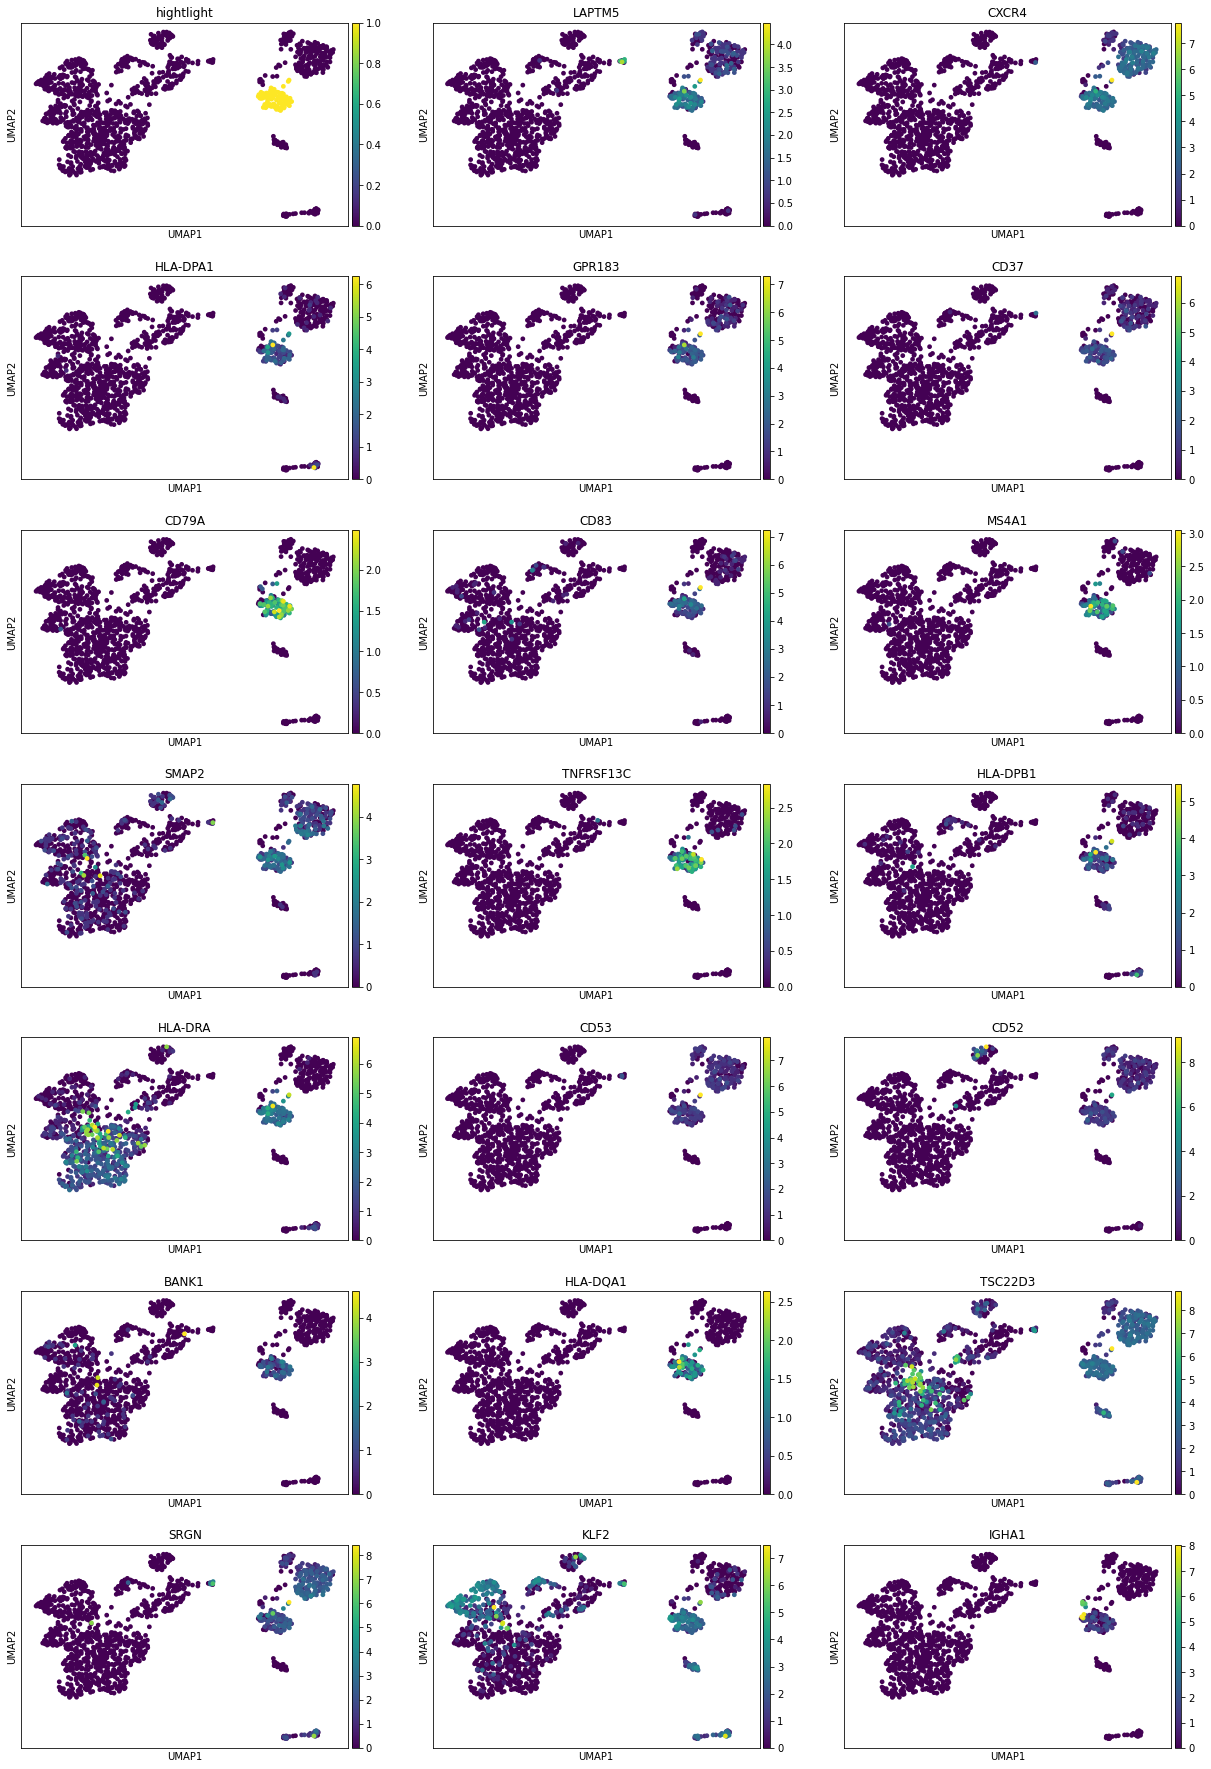

In [27]:
topgenes = list(DE["0"].T[:20].index)
organ_adata.obs["hightlight"] = organ_adata.obs["leiden"] == "0"
sc.pl.umap(
    organ_adata,
    color=["hightlight"] + topgenes,
    ncols=3,
)

You can do this for other clusters as well. Here I plot the top 5 genes for all other clusters

0


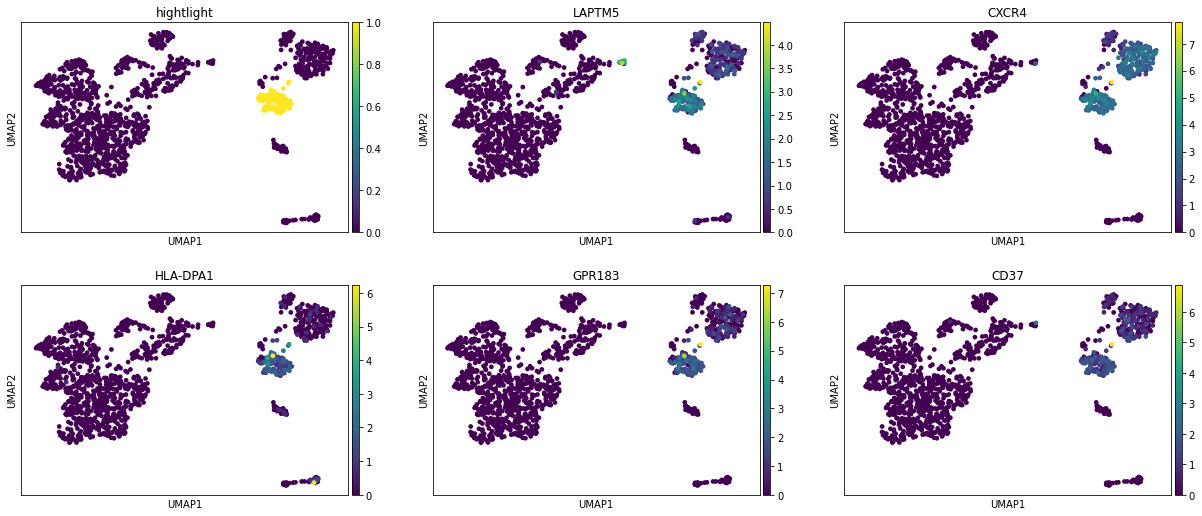

1


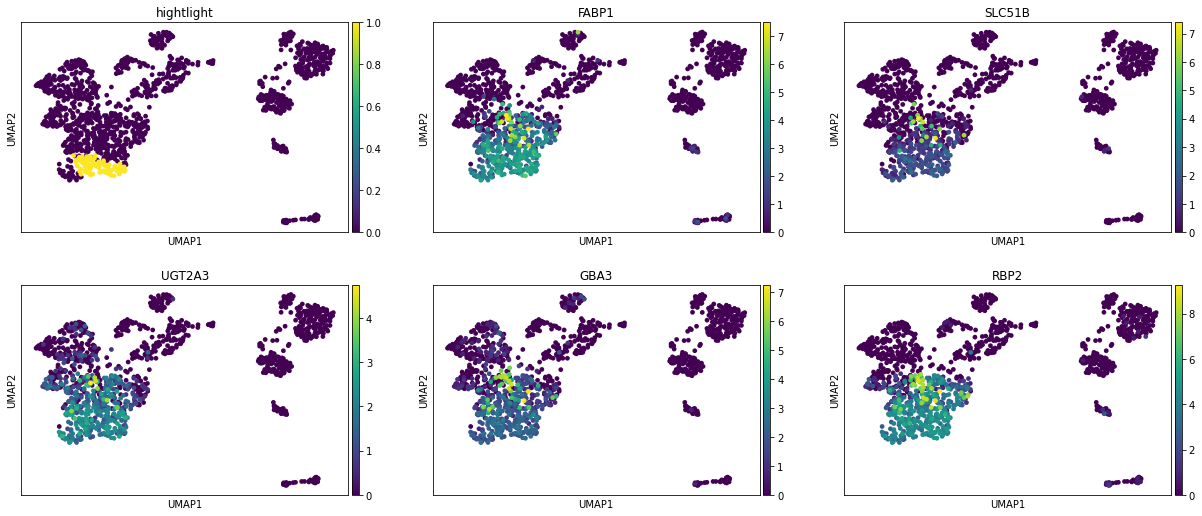

2


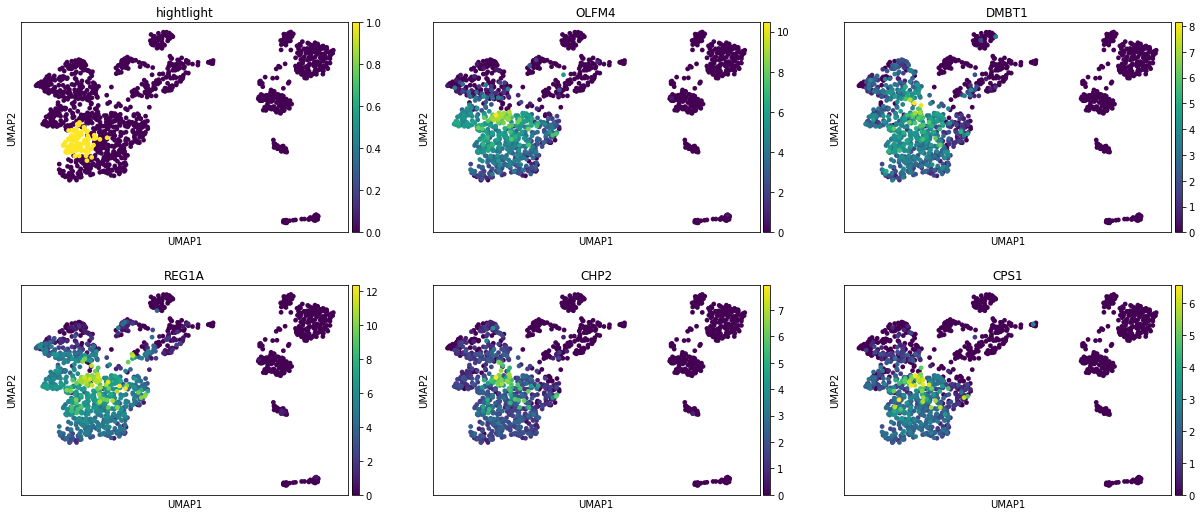

3


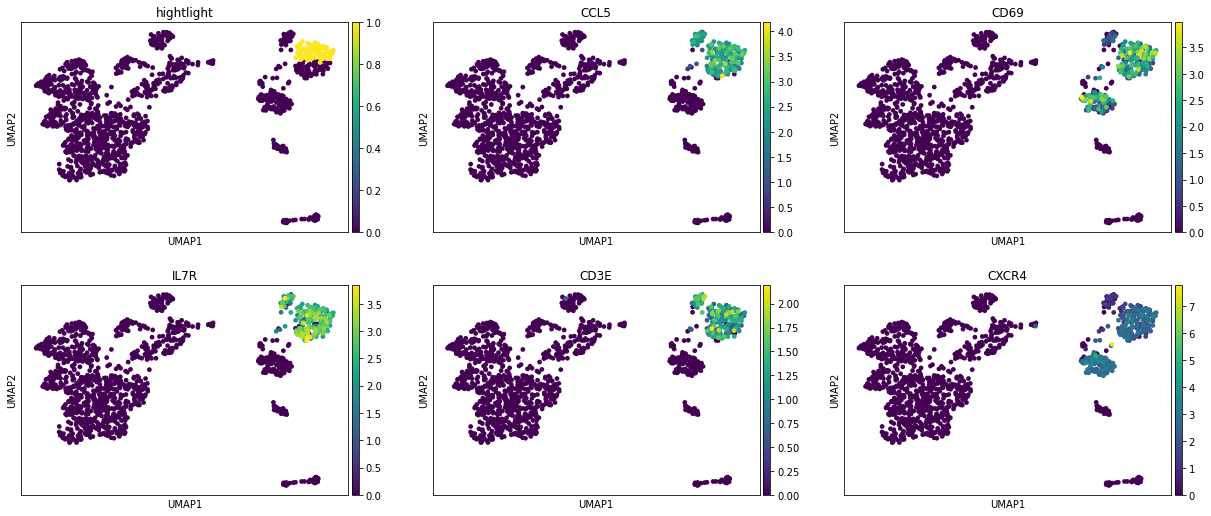

4


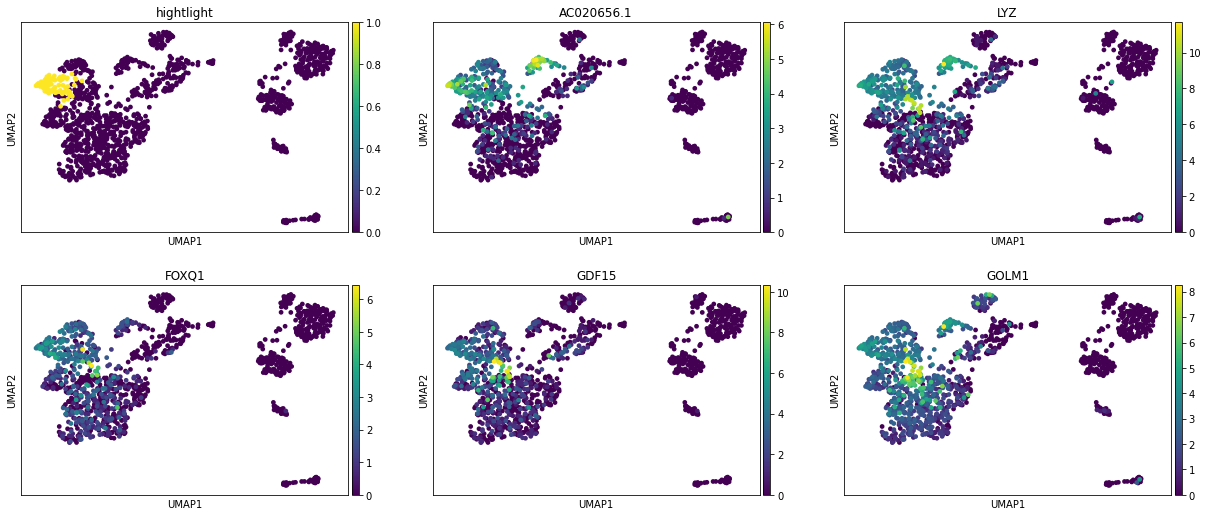

5


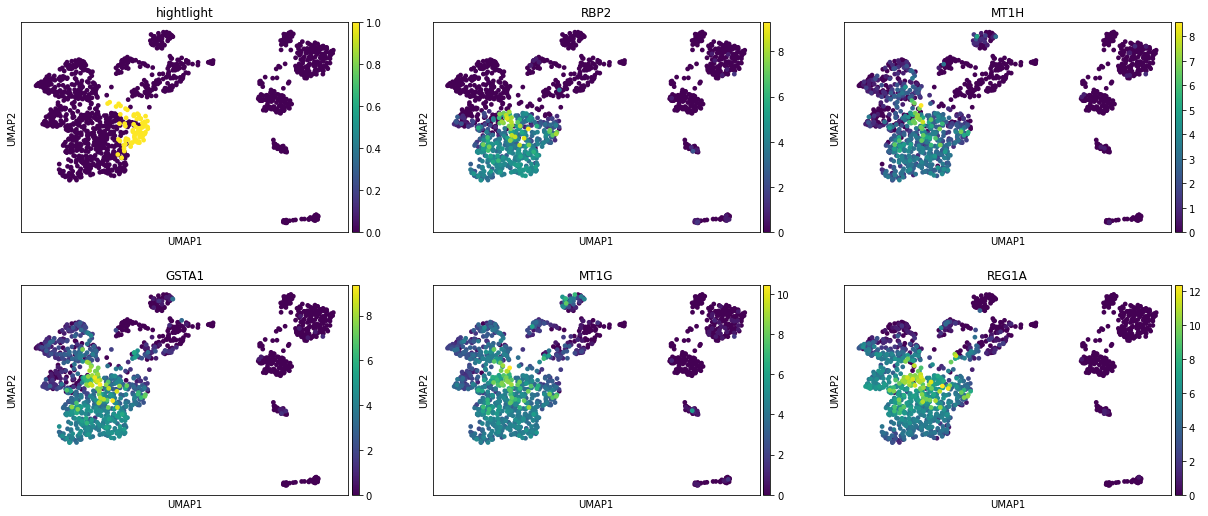

6


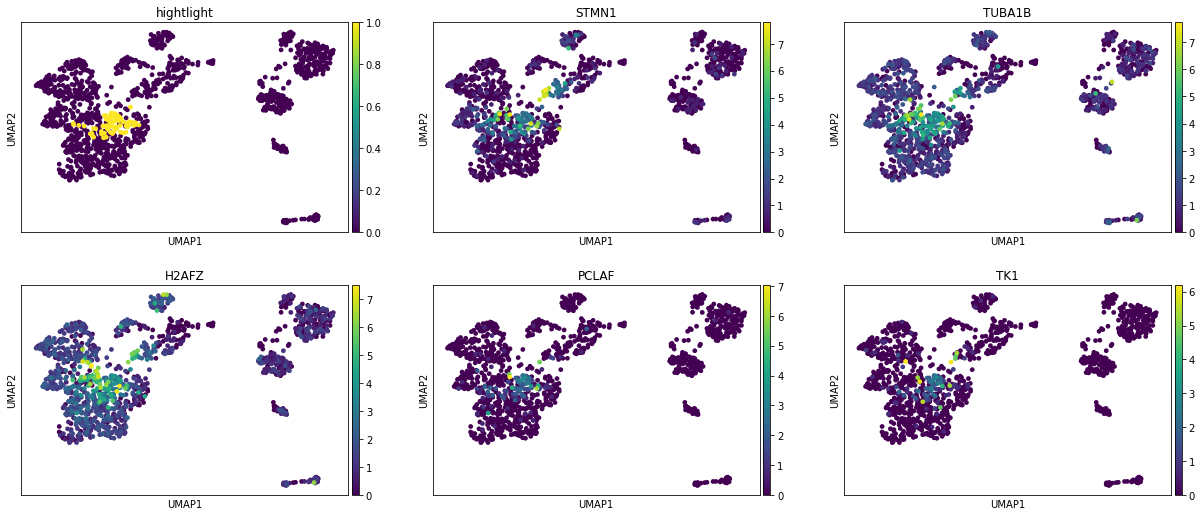

7


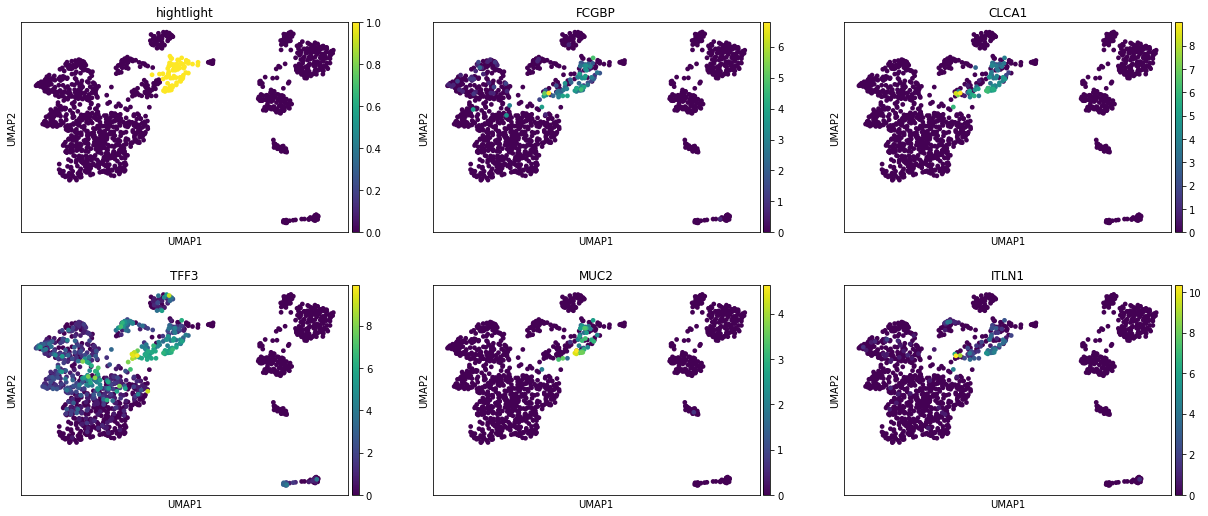

8


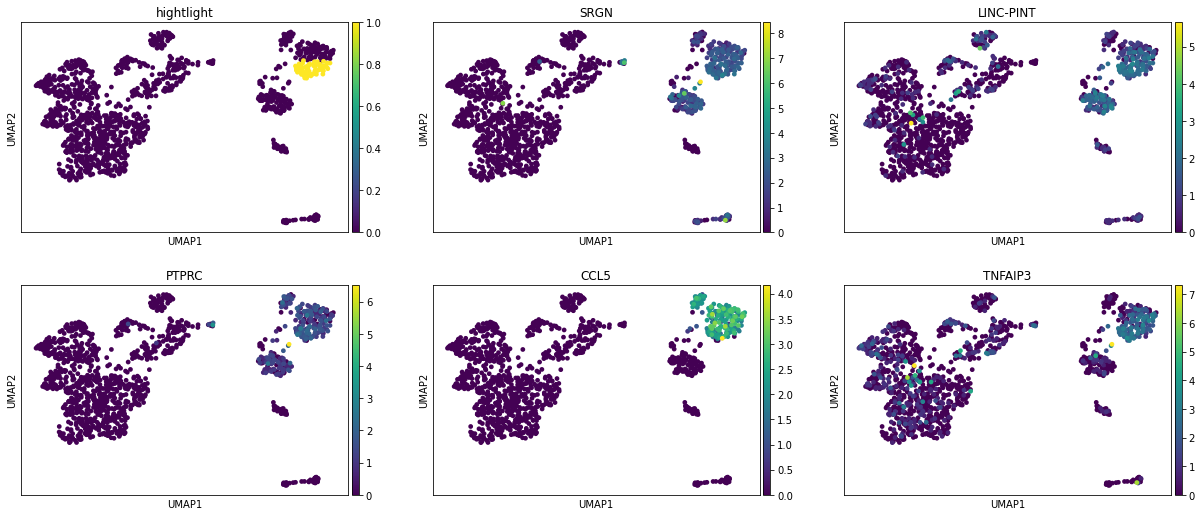

9


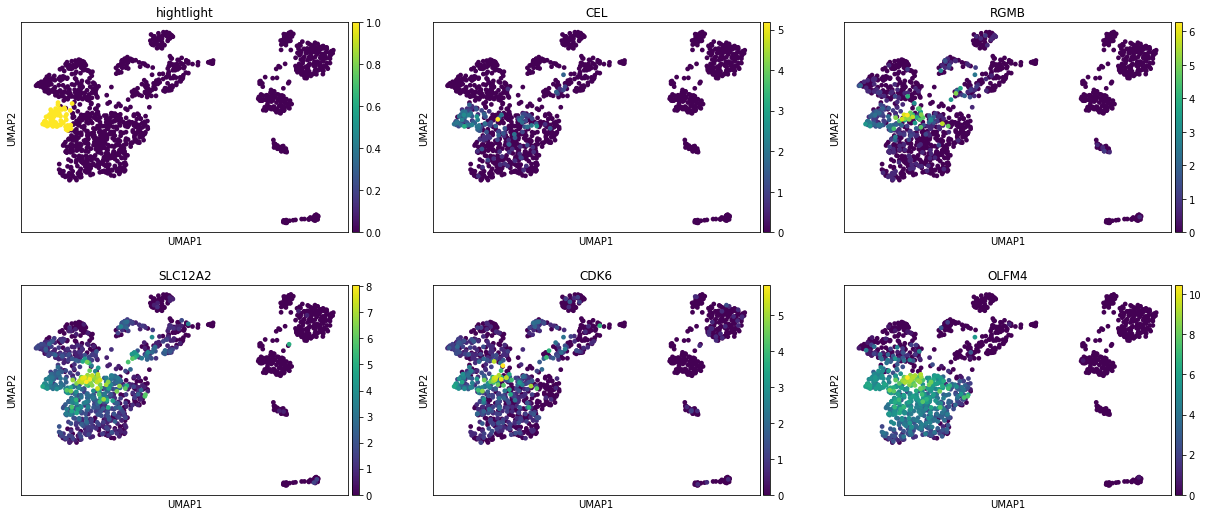

10


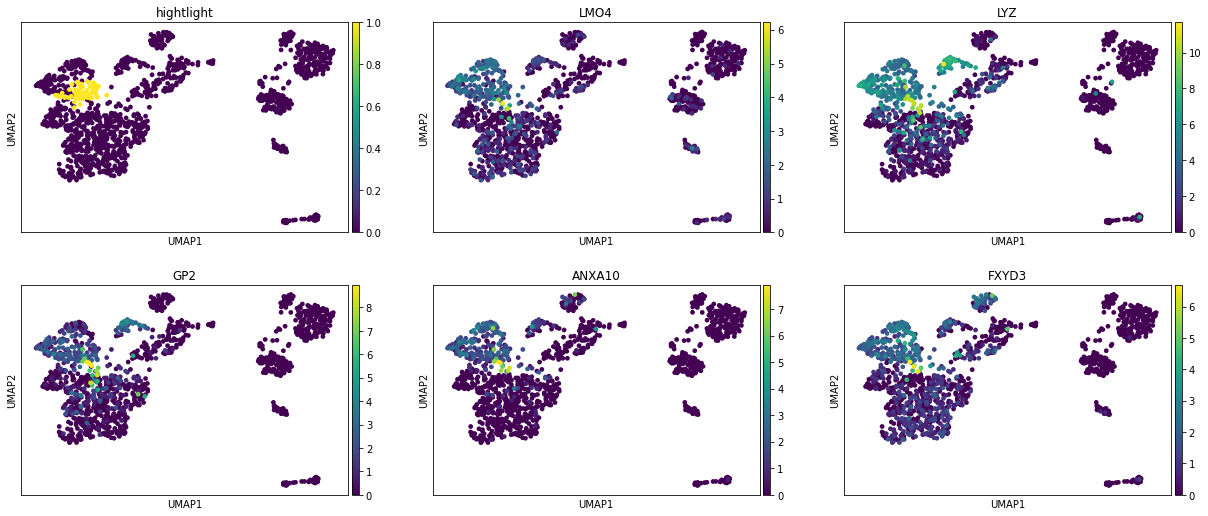

11


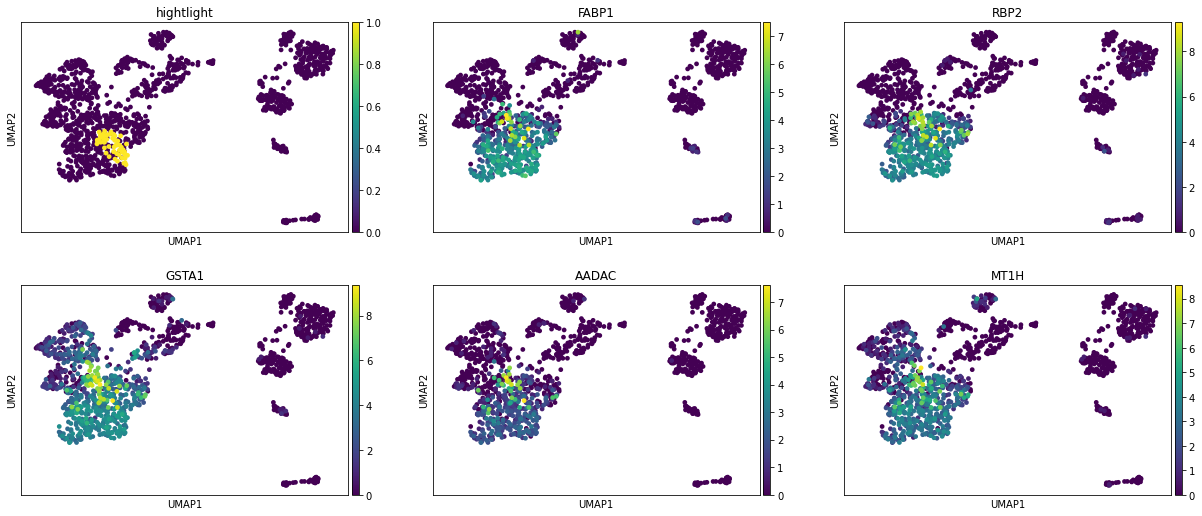

12


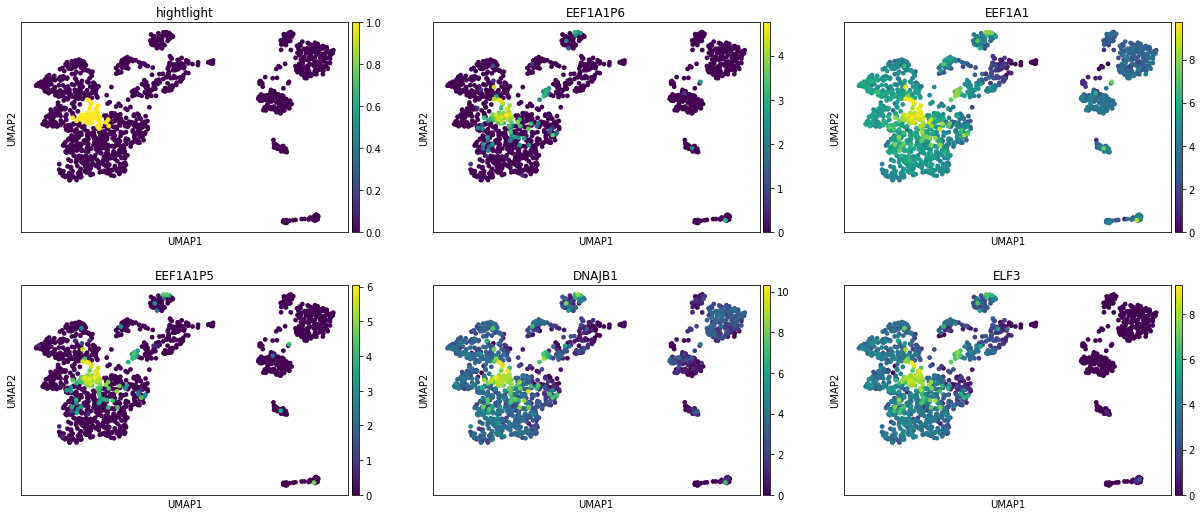

13


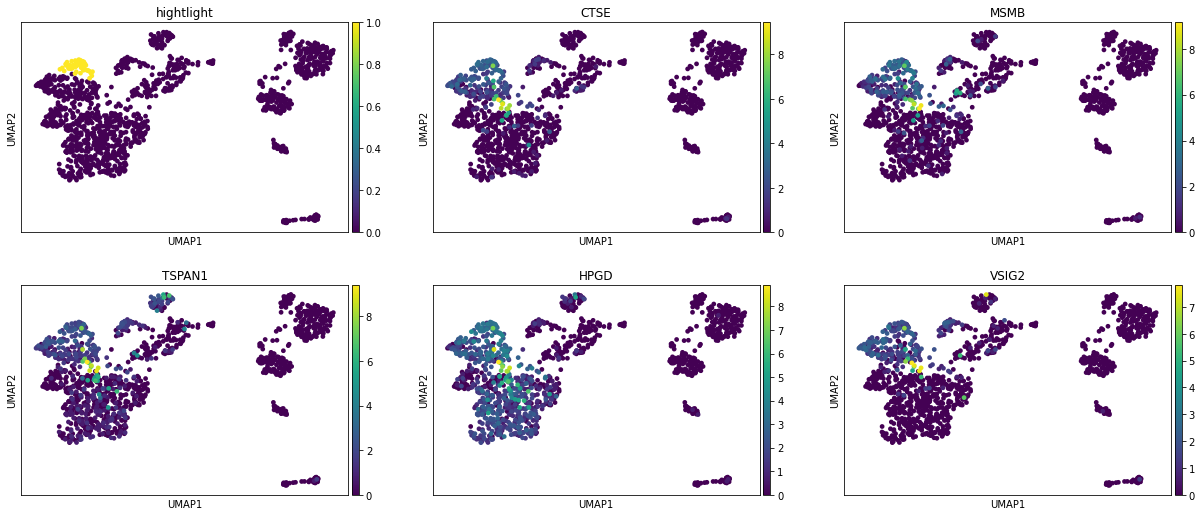

14


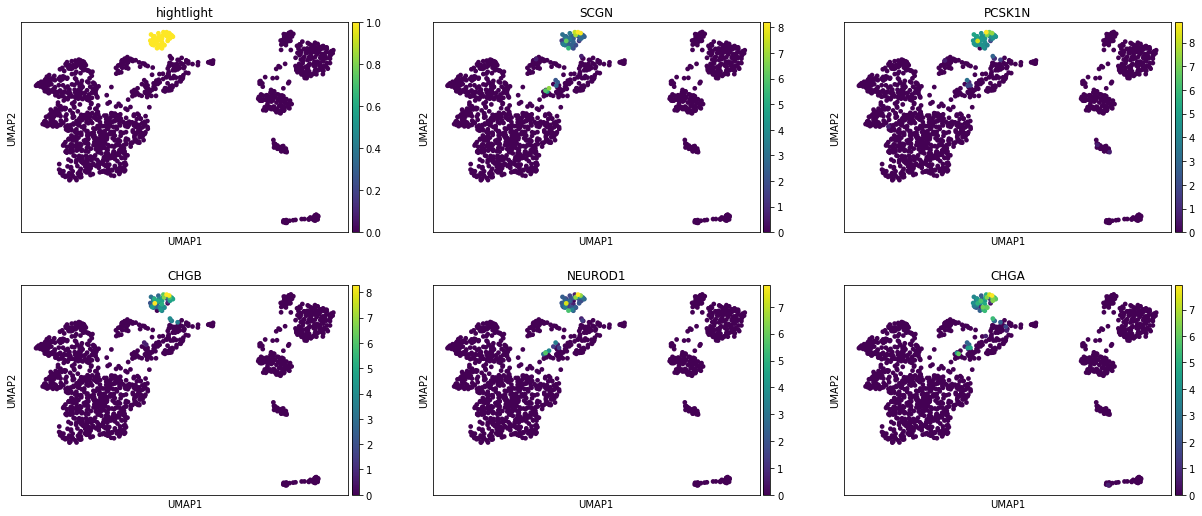

15


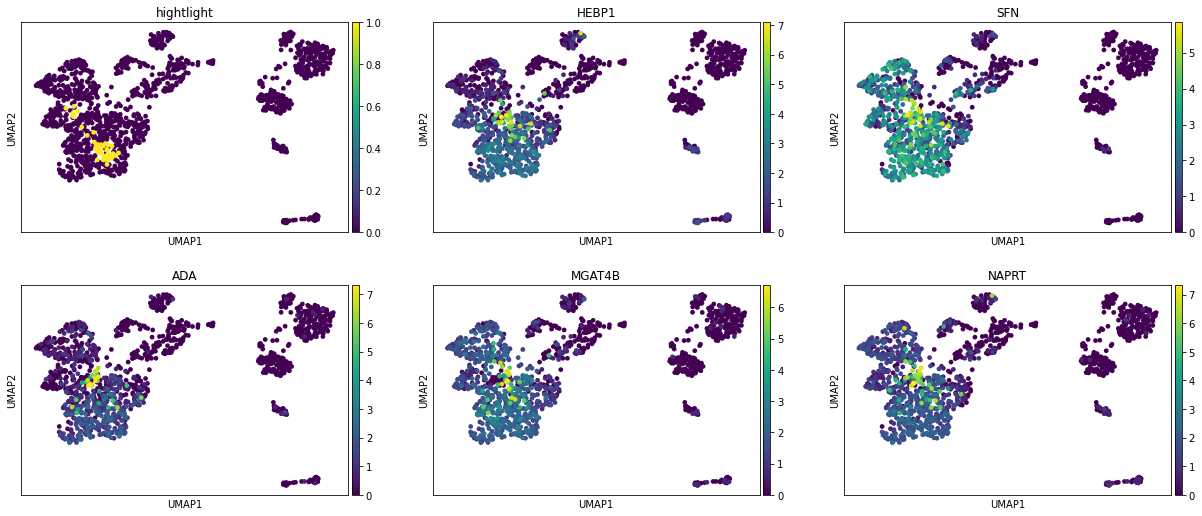

16


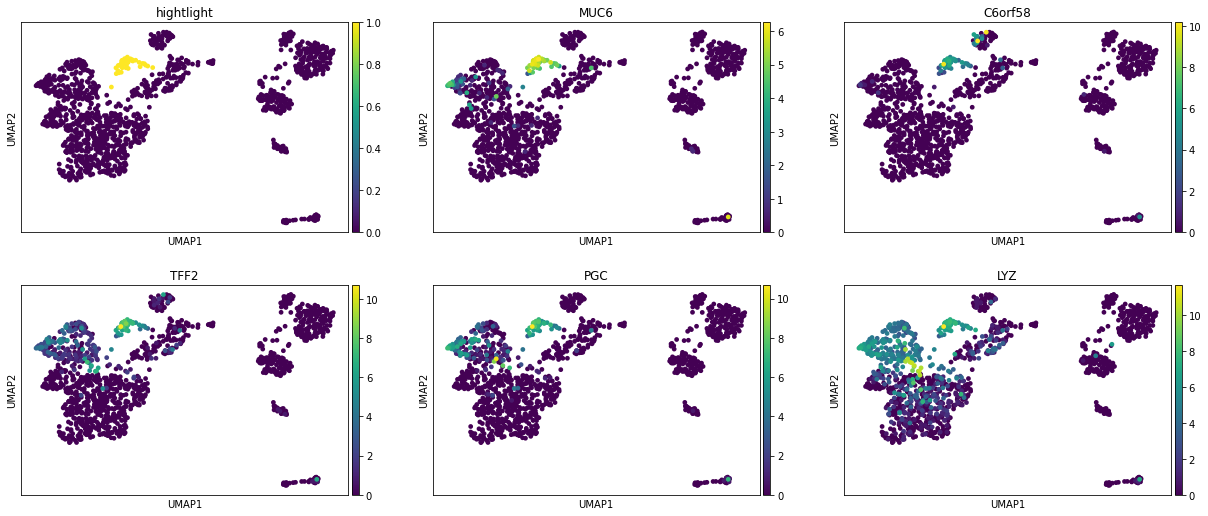

17


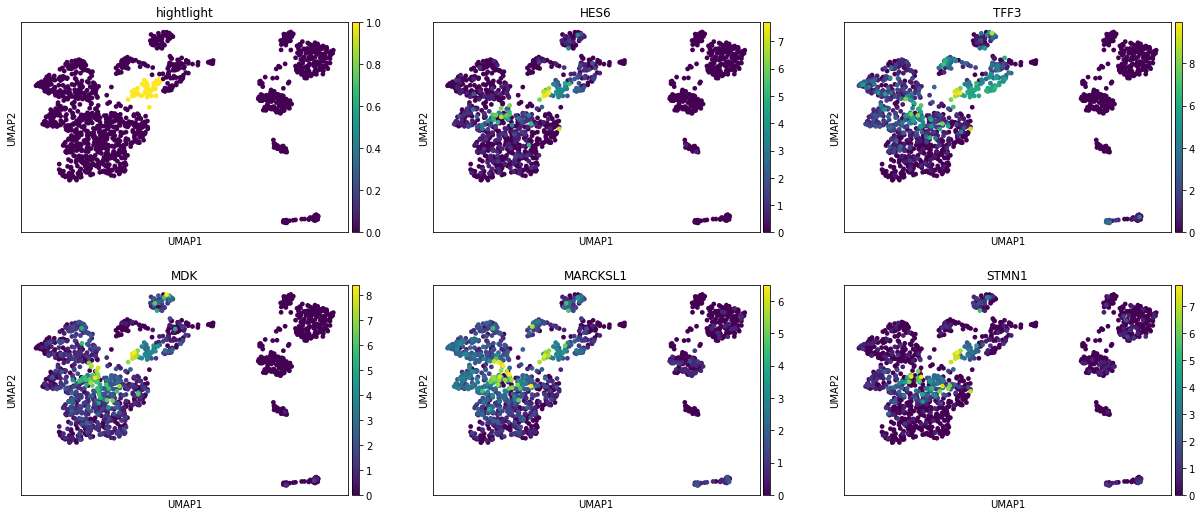

18


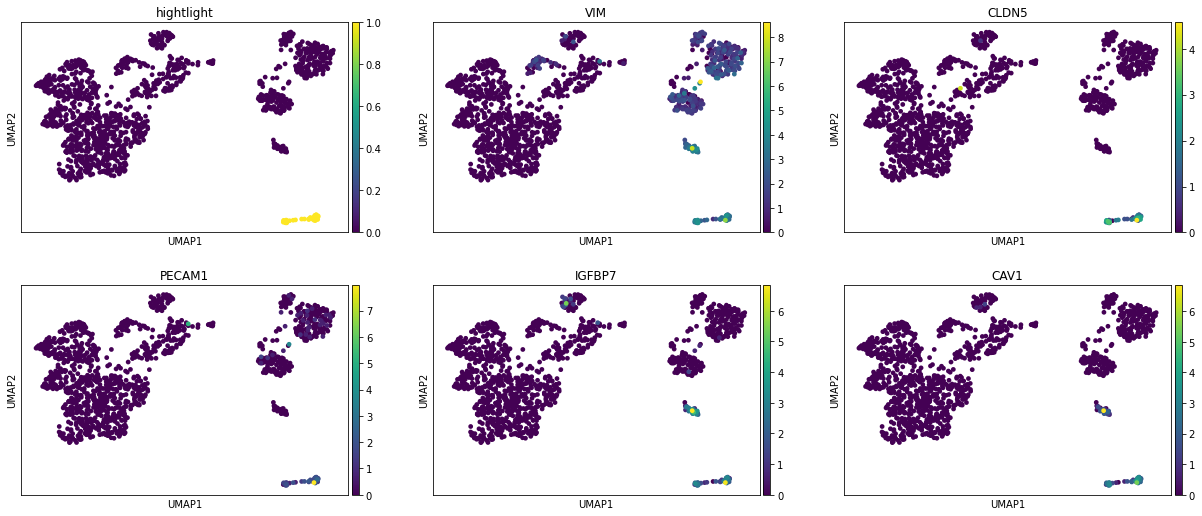

19


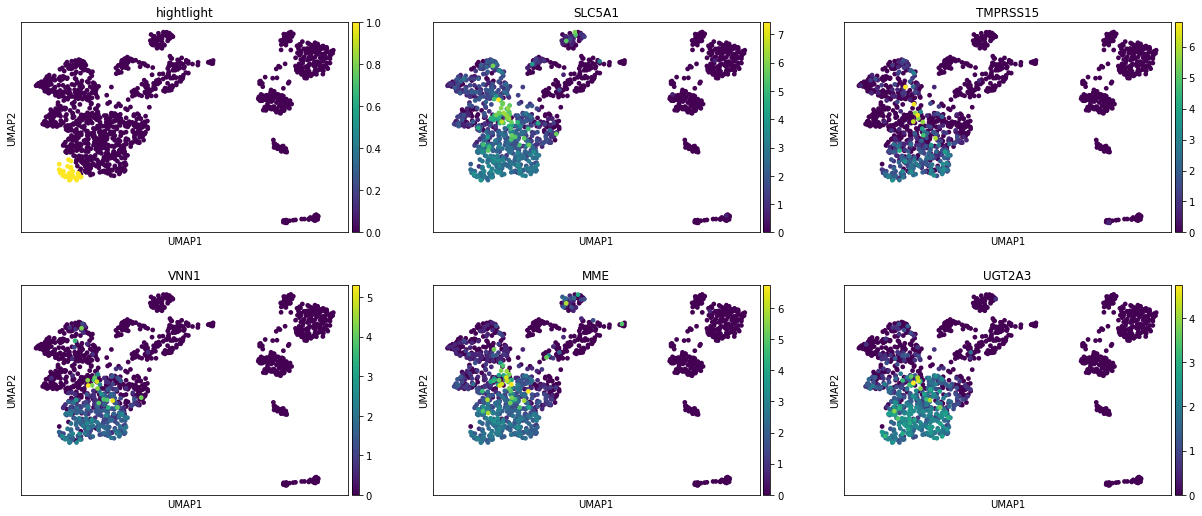

20


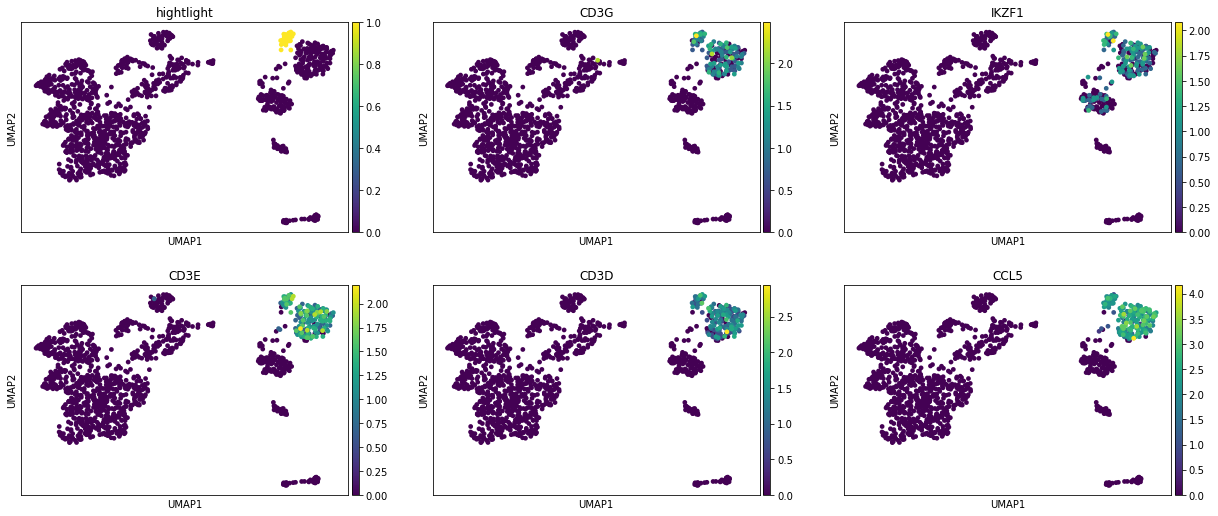

21


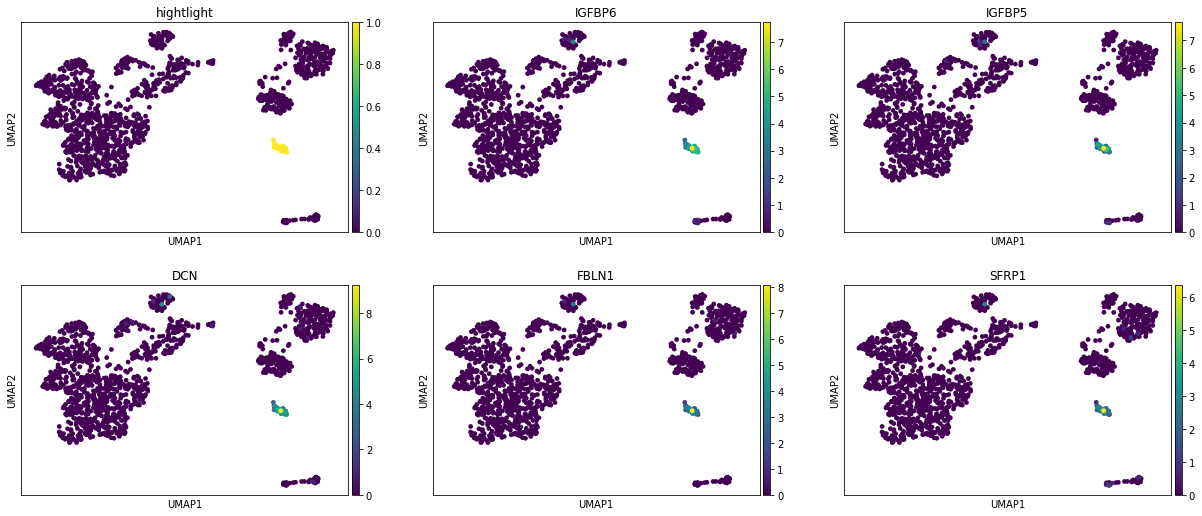

22


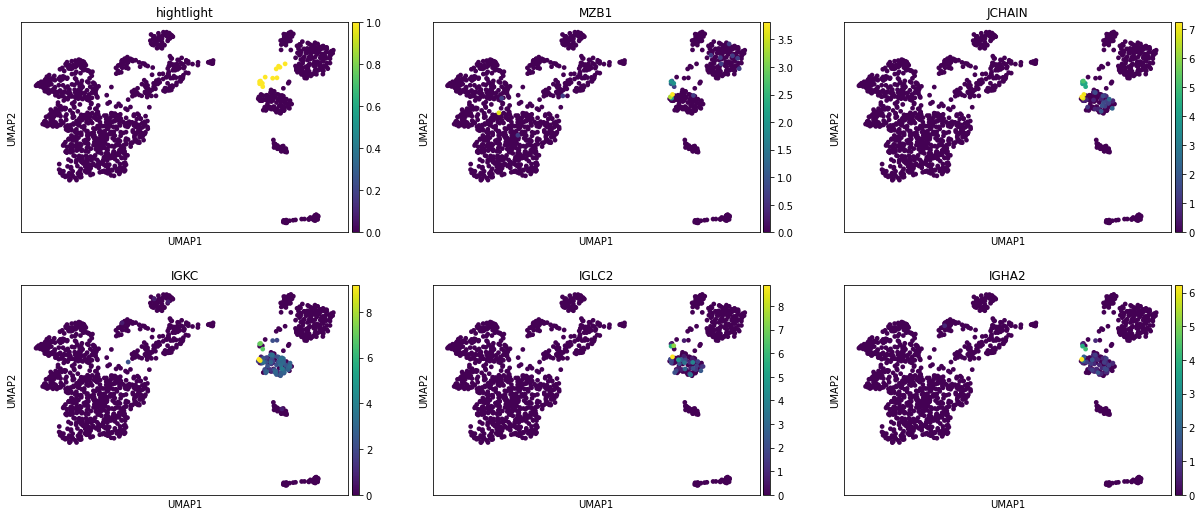

23


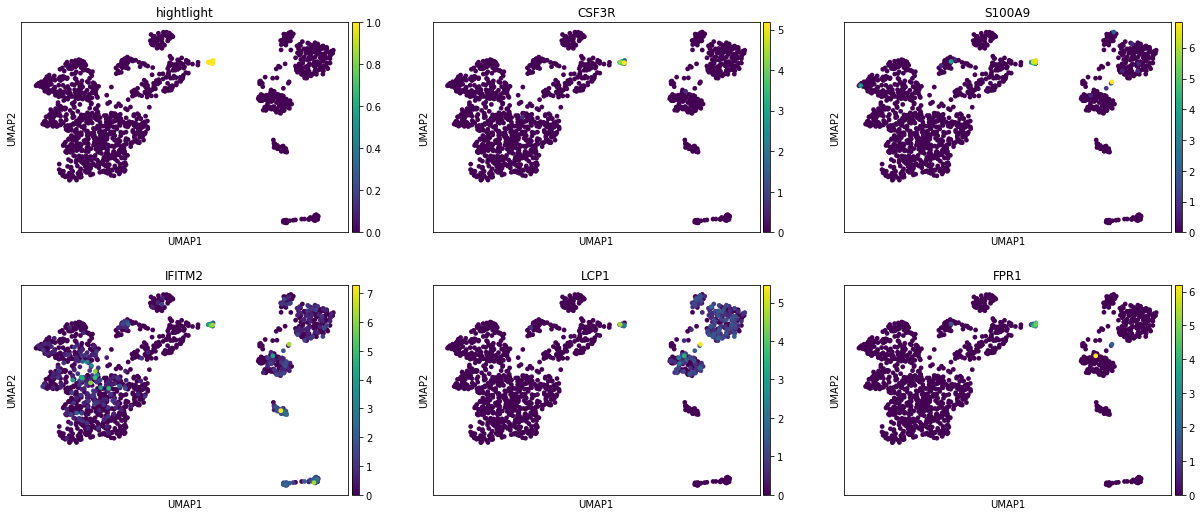

In [28]:
for x in DE.keys():
    print(x)
    topgenes = list(DE[x].T[:5].index)
    organ_adata.obs["hightlight"] = organ_adata.obs["leiden"] == x
    sc.pl.umap(
        organ_adata,
        color=["hightlight"] + topgenes,
        ncols=3,
    )

### The extended DE list can be queried by 

In [29]:
DE["0"].T

wilcoxon_score  log fold change  adjusted pvalue
LAPTM5         14.674339         5.268868     5.541279e-44
CXCR4          14.089197         5.046943     8.580366e-41
HLA-DPA1       14.081161         6.548367     8.580366e-41
GPR183         14.069719         6.054896     8.580366e-41
CD37           13.961026         5.050691     3.173375e-40
...                  ...              ...              ...
LGALS3        -12.980748        -6.353957     7.718613e-35
MT2A          -13.252071        -9.619744     2.349003e-36
MT-CO3        -13.342104        -3.113392     7.752537e-37
MT-CO1        -13.461285        -3.184278     1.944771e-37
MT-CO2        -13.539740        -3.389382     7.662436e-38

[58870 rows x 3 columns]

# read in cell ontology 

In [30]:
import obonet

ont_dir = "/data/yosef2/users/chenling/TabulaSapiensData/ontology/"
obo = ont_dir + "cl.obo.txt"
f = open(obo, "r")
co = obonet.read_obo(f)
f.close()

celltype_dict = {}
for x in co.nodes:
    celltype_dict[co.nodes[x]['name']] = x



You can look up all T cell by typing celltype_dict['T'] and using tab complete  

In [31]:
celltype_dict["T cell"]

'CL:0000084'

You can also look at the names of all subsets of T cell that contains 'CD4' in their names

In [32]:
import networkx as nx


def PrintChildren(co, parent, pattern=""):
    all_children = [x for x in nx.ancestors(co, celltype_dict[parent])]
    return [co.nodes[x]["name"] for x in all_children if pattern in co.nodes[x]["name"]]


PrintChildren(co, "T cell", "CD4")

['CD4-positive type I NK T cell secreting interleukin-4',
 'CD4-positive, CD8-intermediate double-positive thymocyte',
 'CD4-positive, alpha-beta T cell',
 'activated CD4-positive, alpha-beta T cell',
 'effector memory CD4-positive, alpha-beta T cell',
 'CD4-negative, CD8-negative type I NK T cell secreting interleukin-4',
 'CD4-positive type I NK T cell secreting interferon-gamma',
 'central memory CD4-positive, alpha-beta T cell',
 'CD4-negative, CD8-negative type I NK T cell secreting interferon-gamma',
 'CD2-positive, CD5-positive, CD44-positive alpha-beta intraepithelial T cell',
 'CD69-positive, CD4-positive single-positive thymocyte',
 'CD4-positive type I NK T cell',
 'CD4-intermediate, CD8-positive double-positive thymocyte',
 'activated CD4-positive, alpha-beta T cell, human',
 'activated CD4-positive type I NK T cell',
 'CD4-positive, alpha-beta cytotoxic T cell',
 'CD4-positive, CD25-positive, CCR4-positive, alpha-beta regulatory T cell',
 'mature CD4 single-positive thymoc

# manually create mapping between cluster and cell type (this is just an example), and the relevant marker genes that was used to generate this prediction

In [33]:
organ_adata.obs["annotation_oct2020"] = organ_adata.obs["leiden"].copy()
cluster_mapping = {"0": "T cell"}
cluster_markers = {"0": ["CXCR4", "CD3D", "IL7R", "IL32"]}

This cell will automatically replace the leiden cluster names with cell type annotations

In [34]:
for l in cluster_mapping.keys():
    organ_adata.obs["annotation_oct2020"].replace(l, cluster_mapping[l], inplace=True)
    display(DE[l][cluster_markers[l]])

CXCR4       CD3D       IL7R          IL32
wilcoxon_score   1.408920e+01  -1.962190  -2.255852 -8.516173e+00
log fold change  5.046943e+00 -27.122309 -28.621124 -3.043020e+01
adjusted pvalue  8.580366e-41   0.415290   0.220705  1.628925e-15

# Visualize the results of the manual annotation

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



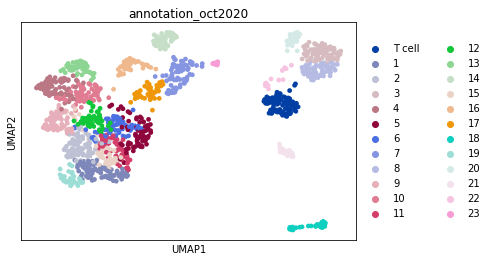

In [35]:
sc.pl.umap(
    organ_adata,
    color=["annotation_oct2020"],
    ncols=3,
)

# create celltype subcluster
This is just an example once the celltype annotations are done, how to subcluster cells in a celltype

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



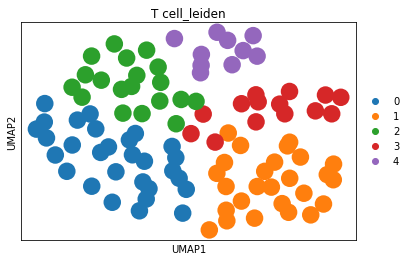

In [36]:
celltype = "T cell"
sub_organ_adata = organ_adata[organ_adata.obs["annotation_oct2020"] == celltype]
sc.pp.neighbors(sub_organ_adata, use_rep="X_scvi_decontX")
sc.tl.umap(
    sub_organ_adata,
)
sc.tl.leiden(sub_organ_adata, resolution=1, key_added="%s_leiden" % celltype)
sc.pl.umap(
    sub_organ_adata,
    color=["%s_leiden" % celltype],
    ncols=3,
)

In [37]:
sc.tl.rank_genes_groups(
    sub_organ_adata, groupby="%s_leiden" % celltype, method="wilcoxon"
)
sub_DE = FormatDE(sub_organ_adata.uns["rank_genes_groups"])

0


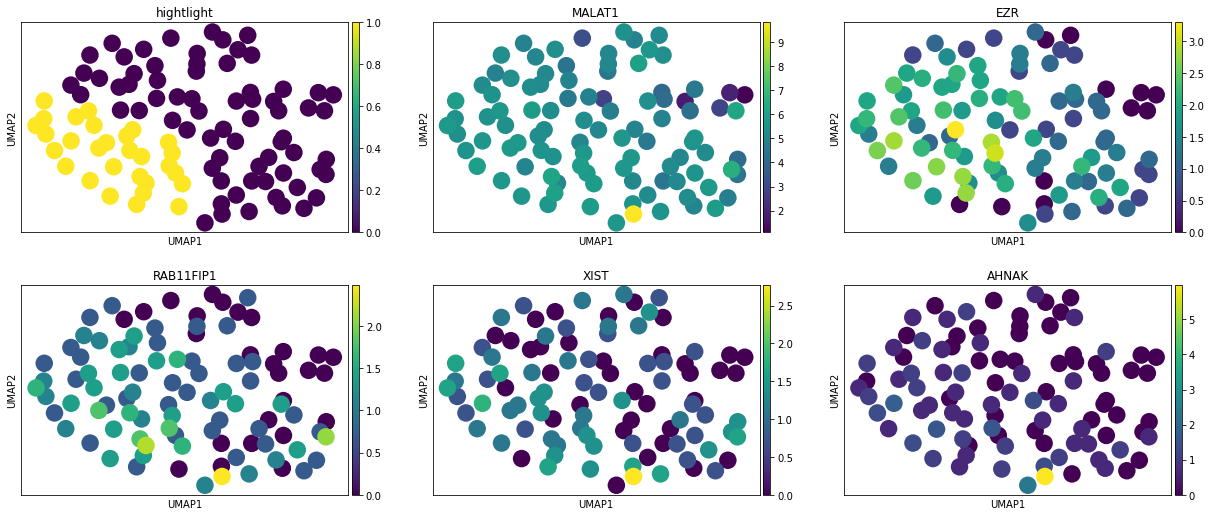

1


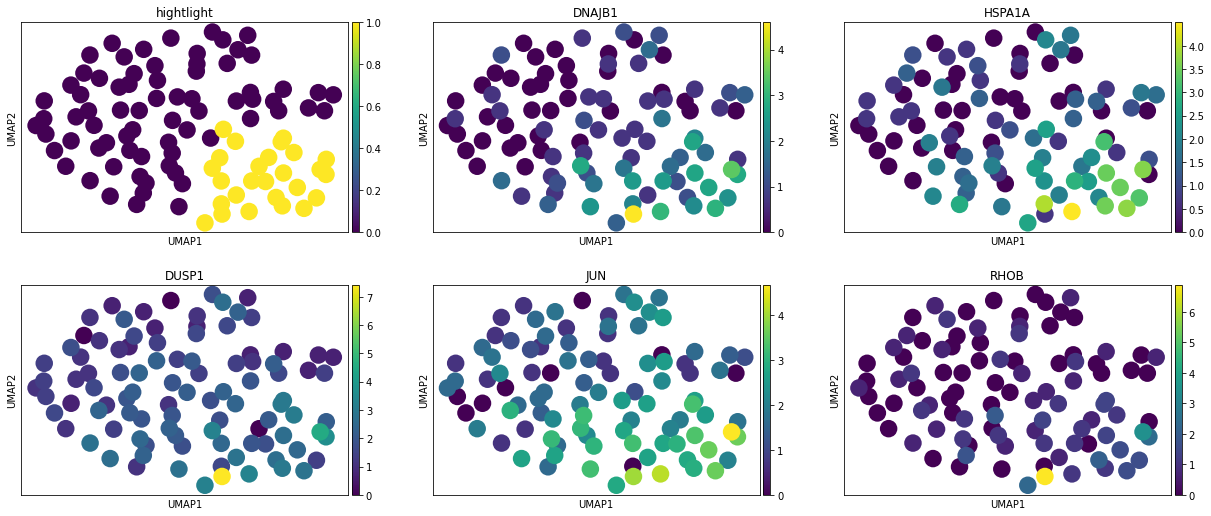

2


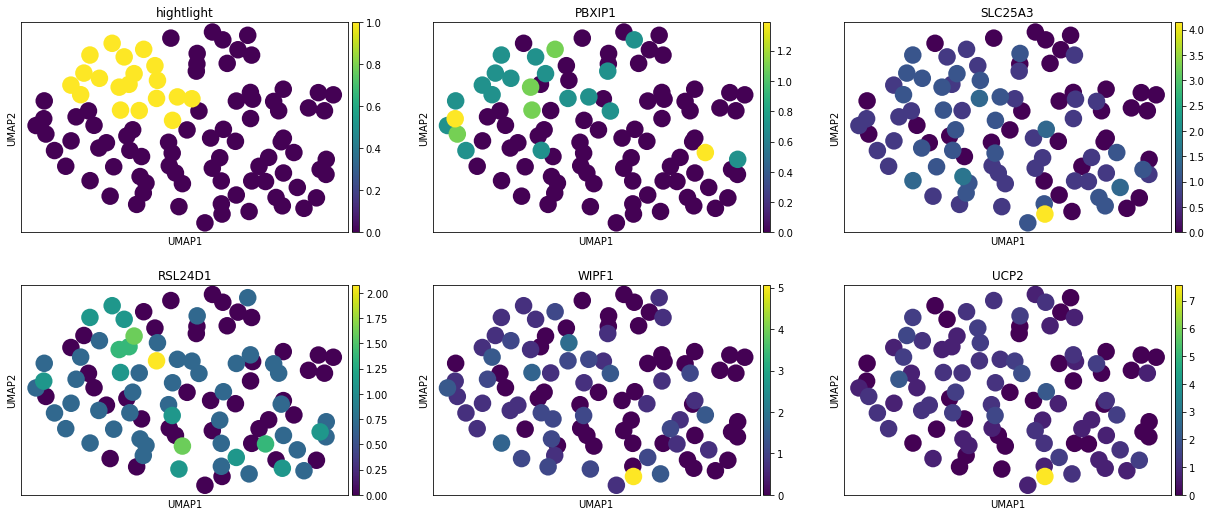

3


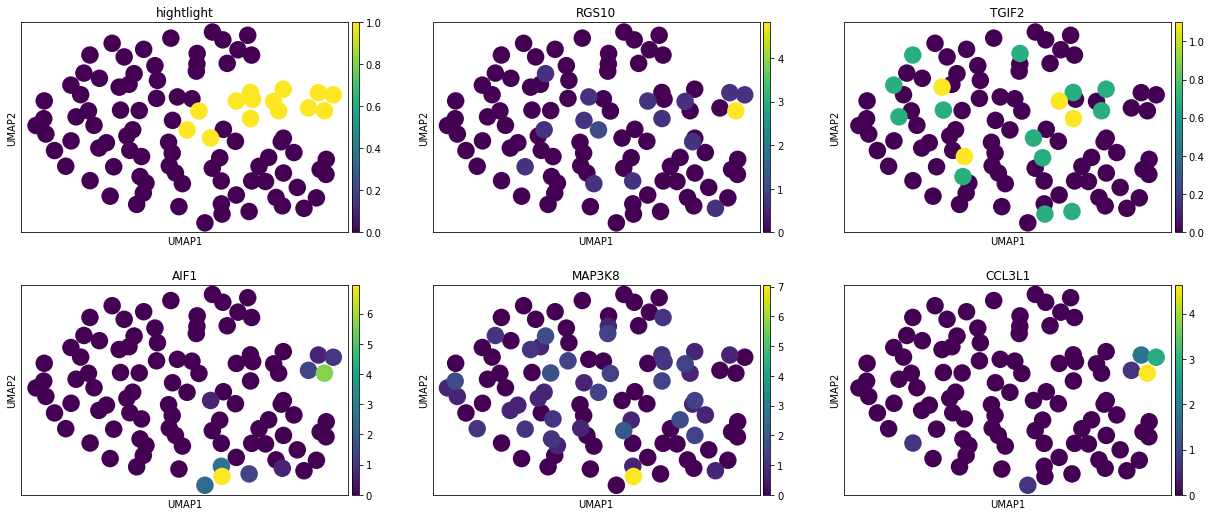

4


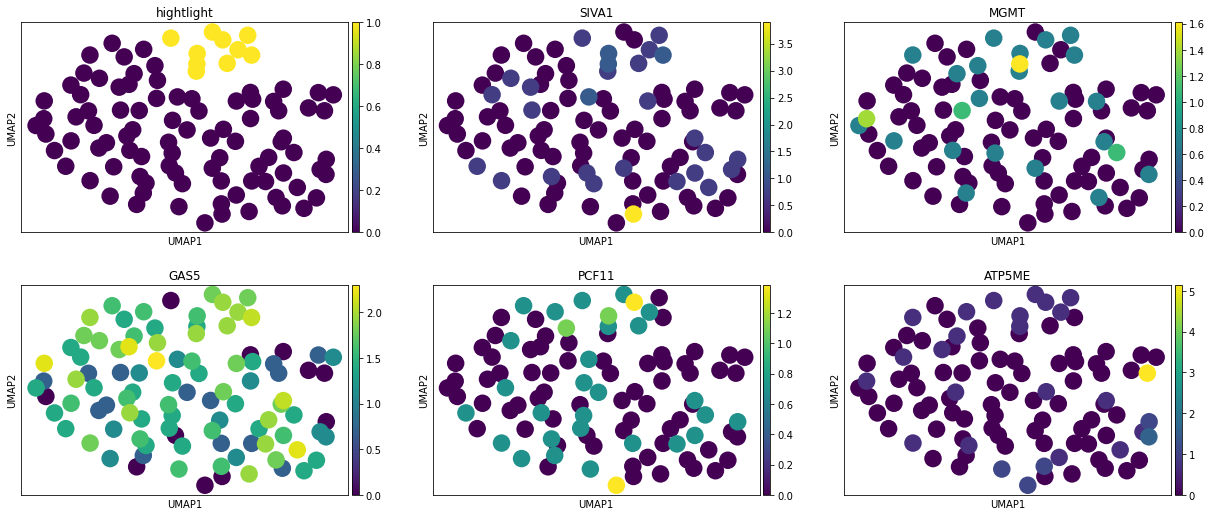

In [38]:
for x in sub_DE.keys():
    print(x)
    topgenes = list(sub_DE[x].T[:5].index)
    sub_organ_adata.obs["hightlight"] = sub_organ_adata.obs["%s_leiden" % celltype] == x
    sc.pl.umap(
        sub_organ_adata,
        color=["hightlight"] + topgenes,
        ncols=3,
    )

# manually create mapping between cell type and compartment (this is just an example)

In [39]:
organ_adata.obs["compartment_oct2020"] = organ_adata.obs["annotation_oct2020"].copy()
compartment_mapping = {"T cell": "Immune"}

This cell will automatically replace the leiden cluster names with cell type annotations

In [40]:
for c in compartment_mapping.keys():
    organ_adata.obs["compartment_oct2020"].replace(
        c, compartment_mapping[c], inplace=True
    )

# Visualize the results of the new compartment splitting

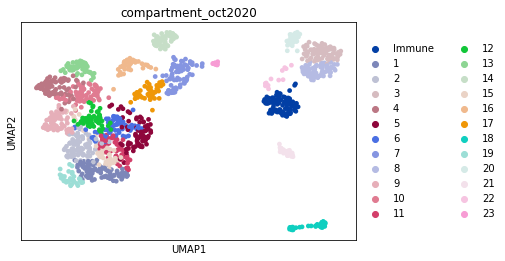

In [41]:
sc.pl.umap(
    organ_adata,
    color=["compartment_oct2020"],
    ncols=3,
)

# save data

In [42]:
organ_adata.write_h5ad(
    data_path + "decontX/organ_data/Pilot1_Pilot2.decontX.%s.h5ad" % organ
)